# Assesssing the Full Burden of EIDs

---

## Table of Contents

1. [Introduction](#Introduction)
2. [Data Loading](#Data-Loading)
3. [Combining Datasets](#Combining-Datasets)
4. [Calculation of Per Case Direct and Indirect Costs](#Calculation-of-Per-Case-Direct-and-Indirect-Costs)
5. [Loading Incidence and Death Data](#Loading-Incidence-and-Death-Data)
6. [Calculation of Total Direct and Indirect Costs](#Calculation-of-Total-Direct-and-Indirect-Costs)
7. [Calculation of Total Direct and Indirect Costs](#Calculation-of-Total-Direct-and-Indirect-Costs)
8. [Loading Dalys, VSL, Equity Weights and Other Data and Full Burden Calculations](#Loading-DALYs-VSL-Equity-Weights-Data)
9. [Historical Charts](#Historical-Charts)
10. [Monte Carlo Simulations](#Monte-Carlo-Simulations)


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter
import numpy as np
import seaborn as sns
from   matplotlib.ticker import ScalarFormatter
from   scipy.stats import linregress
import scipy.stats as stats
from   matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as mticker
import random
import time
from   datetime import datetime
from   IPython.display import display, Markdown
import matplotlib.ticker as mtick


In [2]:
# Change working directory
os.chdir('...')
today_date = datetime.today().strftime('%Y-%m-%d')

# Data-Loading

In [3]:
# Import data
locc        = pd.read_excel (".../master_study_country_list.xlsx")
los         = pd.read_excel (".../length_of_stay.xlsx")
pop         = pd.read_excel (".../country_year_population.xlsx")
tu          = pd.read_excel (".../time_use_data.xlsx")
wages       = pd.read_stata (".../hrly_wage_USD_2000_2022.dta")
hb          = pd.read_excel (".../direct_costs.xlsx")
dengue_all  = pd.read_csv   (".../Data Explorer - Data - Dengue - 2050.csv")
dengue      = pd.read_excel (".../Data Explorer - Data - Dengue.xlsx")
cholera     = pd.read_excel (".../Data Explorer - Data - Cholera.xlsx")
covid19     = pd.read_excel (".../Data Explorer - Data - COVID-19.xlsx")
covid19_all = pd.read_csv   (".../Data Explorer - Data - COVID-19 - 2050.csv")
covid19_oth = pd.read_excel (".../Data Explorer - Data - Other COVID-19.xlsx")
ntd_all     = pd.read_excel (".../Data Explorer - Data - Neglected tropical diseases and malaria - 2050.xlsx")
ontd        = pd.read_excel (".../Data Explorer - Data - Other neglected tropical diseases.xlsx")
ontd_all    = pd.read_csv   (".../Data Explorer - Data - Other neglected tropical diseases - 2050.csv")
ebola_ihme  = pd.read_excel (".../Data Explorer - Data - Ebola.xlsx")
zika        = pd.read_excel (".../Data Explorer - Data - zika.xlsx")
zika_asym   = pd.read_excel (".../Data Explorer - Data - Asymptomatic Zika.xlsx")
dalys       = pd.read_stata (".../dalys_per_case_2000_2022_12_eids.dta")
equity_wt   = pd.read_excel (".../economic/equity_df.xlsx")
vsl         = pd.read_excel (".../economic/vsl_df.xlsx")
h1n1        = pd.read_excel (".../h1n1_cases_deaths.xlsx")
h1n1_dalys  = pd.read_excel (".../h1n1_dalys.xlsx")
mers_dalys  = pd.read_excel (".../mers_dalys.xlsx")
sars_dalys  = pd.read_excel (".../sars_dalys.xlsx")
covid_dalys = pd.read_excel (".../covid_dalys.xlsx",sheet_name="median")
sars        = pd.read_excel (".../sars_cases_deaths.xlsx", sheet_name="Data Cleaned")
mers        = pd.read_excel (".../mers_symp_cases_deaths.xlsx")
nipah       = pd.read_excel (".../nipah_cases_deaths.xlsx", sheet_name="Data")
gr          = pd.read_excel (".../growth_rate_df.xlsx")
covid19_2022= pd.read_stata (".../covid_deaths_ratio_2022_v_2021.dta")
covid19_asym= pd.read_excel (".../covid_asymp_ratios.xlsx")

<div style="font-size: 90%;">
$$
\text{Per Case Direct Cost} = \color{red}{\text{Hospitalization Rate} \times \text{Length of Stay}} \times \text{Cost per Hospital Bed Day (2022)}
$$
</div>

<div style="font-size: 90%;">
$$
\text{Per Case Indirect Cost} = \color{red}{\text{Hospitalization Rate} \times \text{Length of Stay}} \times (\text{Hours per Day of Paid Work} + \text{Hours Per Day of Unpaid Work}(2022)) \times \text{Hourly Wage (2022)}
$$
</div>


# Combining-Datasets

In this section, multiple input files are read, transformed to ensure variable consistency, merged, and cleaned for data integrity.

In [4]:
# Merge location and length of stay dataframes

locc                           = locc.reset_index(drop=True)
los                            = los.reset_index(drop=True)

df                             = locc.assign(key=1).merge(los.assign(key=1), on='key').drop('key', axis=1)
df                             = df.rename(columns ={'country': 'Country'})
df                             = df.drop_duplicates()

countries_to_drop              = [
                                 "Saint Martin / Sint Maarten"
]

df                             = df[~df['Country'].isin(countries_to_drop)]


In [5]:
# Merge Time Use Data

df1                            = pd.merge(df, tu, left_on ='Country', right_on='country', how='left')

df1                            = df1.rename(columns={
                                    'health': 'Health_Flag',
                                    'vsl': 'VSL_Flag',
                                    'direct_costs': 'Direct_Cost_Flag',
                                    'equity_weight': 'EW_Flag',
                                    'time_use': 'TU_Flag',
                                    'hourly_wage': 'Hourly_Wage_Flag'
})

columns_to_drop                = ['Note / Source', 'country', 'Proxy Disease', 'Moderate', 'Mild_Moderate']
df1                            = df1.drop(columns=columns_to_drop)

df1['Paid Work Time HR']       = df1['paid'] / 60
df1['Unpaid Work Time HR']     = df1['unpaid'] / 60
df1                            = df1[
                                    [
                                        'Country', 
                                        'who_region',
                                        'yr2022_pcgdp',
                                        'Disease', 
                                        'Hospitalization Rate', 
                                        'Length of Stay', 
                                        'Paid Work Time HR', 
                                        'Unpaid Work Time HR',
                                        'CFR'
                                    ]
]

df1                            = df1.drop_duplicates()


In [6]:
# Expand to have all historical years from 2000 to 2022 

years = pd.date_range(start='2000', end='2023', freq='Y').year
df2   = pd.concat([df1.assign(Year=year) for year in years], ignore_index=True)
df2   = df2.drop_duplicates()


In [7]:
# Merge with Hourly wage Data

wages.rename(columns={'country': 'Country','year':'Year'}, inplace=True)
df31                      = pd.merge(df2, wages, on=['Country', 'Year'], how='left')

df31.rename(columns={'hrly_wage_USD': 'Hourly Wage'}, inplace=True)

df31                      = df31[
                                [
                                    'Country', 
                                    'who_region',
                                    'yr2022_pcgdp',
                                    'Disease', 
                                    'Hospitalization Rate', 
                                    'Length of Stay', 
                                    'Paid Work Time HR', 
                                    'Unpaid Work Time HR',
                                    'Year',
                                    'CFR',
                                    'Hourly Wage'
                                ]
]

# Dealing with Missing Wages

df31['Missing Wage Flag'] = df31['Hourly Wage'].isna()
df31['Hourly Wage'].fillna(df31['yr2022_pcgdp'] * 0.0004281, inplace=True)

columns_to_drop           = [
                                    'Missing Wage Flag'
]

df31                      = df31.drop(columns=columns_to_drop)

df31                      = df31.drop_duplicates()
df3                       = df31.copy()


# Calculation-of-Per-Case-Direct-and-Indirect-Costs
In this section we calculate per case direct and indirect costs

In [8]:
# Calculate Per Case Direct and Indirect costs

df3['PC Indirect Cost Paid']   = df3['Hospitalization Rate'] * df3['Length of Stay'] * df3['Paid Work Time HR'] * df3['Hourly Wage']
df3['PC Indirect Cost Unpaid'] = df3['Hospitalization Rate'] * df3['Length of Stay'] * df3['Unpaid Work Time HR'] * df3['Hourly Wage']
df3['PC Indirect Cost']        = df3['PC Indirect Cost Paid']   + df3['PC Indirect Cost Unpaid']


df4                            = pd.merge(df3, hb, left_on ='Country', right_on='country', how='left')
df4.rename(columns={'severe_2022_usd': 'Cost PHBD'}, inplace=True)
df4.drop(columns=['mild_2022_usd'], inplace=True)

df4['PC Direct Cost']          = df4['Hospitalization Rate'] * df4['Length of Stay'] * df4['Cost PHBD']
df4                            = df4.drop_duplicates()

# Loading-Incidence-and-Death-Data
In this section, incidence data is sourced from multiple inputs and combined with the per-case cost calculations. Using incidence and death figures, the total direct and indirect costs will be computed in the following section.

In [9]:
# Number of Cases and Death Data for IHME Diseases

# DENGUE
dengue                          = dengue.rename(columns={'Condition': 'Disease'})
dengue = dengue.drop(columns    = ['Forecast Scenario'])
dengue.loc[dengue['Location']   == 'Russian Federation', 'Location'] = 'Russia'
dengue.loc[dengue['Location']   == 'Macedonia', 'Location'] = 'North Macedonia'
dengue.loc[dengue['Location']   == 'Swaziland', 'Location'] = 'Eswatini'

dengue_incidence                = dengue[(dengue['Measure'] == 'Incidence') & (dengue['Unit'] == 'Number')]
df5                             = pd.merge(df4, dengue_incidence, left_on=['Country', 'Disease','Year'], right_on=['Location','Disease', 'Year'], how='left')
df5                             = df5.drop(columns=['Sex','Age','Location','Measure','Unit','Lower','Upper','Data Suite'])
df5                             = df5.rename(columns={'Value': 'Incidence'})


dengue_death                    = dengue[(dengue['Measure'] == 'Deaths') & (dengue['Unit'] == 'Number')]
df5                             = pd.merge(df5, dengue_death, left_on=['Country', 'Disease','Year'], right_on=['Location','Disease', 'Year'], how='left')
df5                             = df5.drop(columns=['Sex','Age','Location','Measure','Unit','Lower','Upper','Data Suite'])
df5                             = df5.rename(columns={'Value': 'Death'})

# CHOLERA
cholera                         = cholera.rename(columns={'Condition': 'Disease'})
cholera.loc[cholera['Location'] == 'Russian Federation', 'Location'] = 'Russia'
cholera.loc[cholera['Location'] == 'Macedonia', 'Location'] = 'North Macedonia'
cholera.loc[cholera['Location'] == 'Swaziland', 'Location'] = 'Eswatini'

cholera_incidence               = cholera[(cholera['Measure'] == 'Incidence') & (cholera['Unit'] == 'Number')]
df5                             = pd.merge(df5, cholera_incidence, left_on=['Country', 'Disease','Year'], right_on=['Location','Disease', 'Year'], how='left')
df5                             = df5.drop(columns=['Cause','Sex','Age','Location','Measure','Unit','Lower','Upper','Data Suite'])
df5                             = df5.rename(columns={'Value': 'Incidence_cholera'})

cholera_death                   = cholera[(cholera['Measure'] == 'Deaths') & (cholera['Unit'] == 'Number')]
df5                             = pd.merge(df5, cholera_death, left_on=['Country', 'Disease','Year'], right_on=['Location','Disease', 'Year'], how='left')
df5                             = df5.drop(columns=['Cause','Sex','Age','Location','Measure','Unit','Lower','Upper','Data Suite'])
df5                             = df5.rename(columns={'Value': 'Death_cholera'})


df5['Death']                    = df5.apply(lambda row: row['Death_cholera'] if pd.isnull(row['Death']) else row['Death'], axis=1)
df5['Incidence']                = df5.apply(lambda row: row['Incidence_cholera'] if pd.isnull(row['Incidence']) else row['Incidence'], axis=1)

cholera_cfr                     = los.loc[df5['Disease'] == 'Cholera', 'CFR'].iloc[0]
df5.loc[df5['Disease']          == 'Cholera', 'Incidence'] = df5.loc[df5['Disease'] == 'Cholera', 'Death'].apply(lambda x: x / cholera_cfr if x != 0 else x)

df5                             = df5.drop(columns=['Incidence_cholera','Death_cholera'])

# COVID19
covid19                         = covid19.rename(columns={'Condition': 'Disease'})
covid19                         = covid19.drop(columns=['Forecast Scenario'])

covid19.loc[covid19['Location'] == 'Russian Federation', 'Location'] = 'Russia'
covid19.loc[covid19['Location'] == 'Macedonia', 'Location'] = 'North Macedonia'
covid19.loc[covid19['Location'] == 'Swaziland', 'Location'] = 'Eswatini'

covid19_incidence               = covid19[(covid19['Measure'] == 'Incidence') & (covid19['Unit'] == 'Number')]
df5                             = pd.merge(df5, covid19_incidence, left_on=['Country', 'Disease','Year'], right_on=['Location','Disease', 'Year'], how='left')
df5                             = df5.drop(columns=['Sex','Age','Location','Measure','Unit','Lower','Upper','Data Suite'])
df5                             = df5.rename(columns={'Value': 'Incidence_covid19'})

covid19_death                   = covid19[(covid19['Measure'] == 'Deaths') & (covid19['Unit'] == 'Number')]
df5                             = pd.merge(df5, covid19_death, left_on=['Country', 'Disease','Year'], right_on=['Location','Disease', 'Year'], how='left')
df5                             = df5.drop(columns=['Sex','Age','Location','Measure','Unit','Lower','Upper','Data Suite'])
df5                             = df5.rename(columns={'Value': 'Death_covid19'})

df5['Death']                    = df5.apply(lambda row: row['Death_covid19'] if pd.isnull(row['Death']) else row['Death'], axis=1)
df5['Incidence']                = df5.apply(lambda row: row['Incidence_covid19'] if pd.isnull(row['Incidence']) else row['Incidence'], axis=1)

df5                             = df5.drop(columns=['Incidence_covid19','Death_covid19'])

# COVID Asymptomatic Cases
covid19_asym['Disease']         = 'COVID-19'
covid19_asym                    = covid19_asym.rename(columns={
                                    'country': 'Country',
                                    'year': 'Year',
                                    'asymp_ratio': 'COVID_Asymptomatic_Ratio'
                                })

df5                            = pd.merge(df5, covid19_asym, left_on=['Country', 'Disease','Year'], right_on=['Country','Disease', 'Year'], how='left')

df5.loc[df5['Disease']          == 'COVID-19', 'COVID_all_Incidence'] = df5['Incidence']
df5.loc[df5['Disease']          == 'COVID-19', 'Incidence'] = df5['COVID_all_Incidence'] * (1 - df5['COVID_Asymptomatic_Ratio']).fillna(df5['COVID_all_Incidence'])

# COVID19 Other
covid19_oth                     = covid19_oth.rename(columns={'Condition': 'Disease'})
covid19_oth                     = covid19_oth.drop(columns=['Forecast Scenario'])
covid19_oth['Disease']          = 'COVID-19'
covid19_oth.loc[covid19_oth['Location'] == 'Russian Federation', 'Location'] = 'Russia'
covid19_oth.loc[covid19_oth['Location'] == 'Macedonia', 'Location'] = 'North Macedonia'
covid19_oth.loc[covid19_oth['Location'] == 'Swaziland', 'Location'] = 'Eswatini'

covid19_oth_death              = covid19_oth[(covid19_oth['Measure'] == 'Deaths') & (covid19_oth['Unit'] == 'Number')]

df5                            = pd.merge(df5, covid19_oth_death, left_on=['Country', 'Disease','Year'], right_on=['Location','Disease', 'Year'], how='left')
df5                            = df5.drop(columns=['Sex','Age','Location','Measure','Unit','Lower','Upper','Data Suite'])
df5                            = df5.rename(columns={'Value': 'Death_oth_covid19'})
df5.loc[(df5['Disease']        == 'COVID-19') & (df5['Death_oth_covid19'].isnull()), 'Death_oth_covid19'] = 0

# ZIKA
zika                           = zika.rename(columns={'Condition': 'Disease'})
zika                           = zika.drop(columns=['Forecast Scenario'])
zika.loc[zika['Location']      == 'Russian Federation', 'Location'] = 'Russia'
zika.loc[zika['Location']      == 'Macedonia', 'Location'] = 'North Macedonia'
zika.loc[zika['Location']      == 'Swaziland', 'Location'] = 'Eswatini'

zika_incidence                 = zika[(zika['Measure'] == 'Incidence') & (zika['Unit'] == 'Number')]
df5                            = pd.merge(df5, zika_incidence, left_on=['Country', 'Disease','Year'], right_on=['Location','Disease', 'Year'], how='left')
df5                            = df5.drop(columns=['Sex','Age','Location','Measure','Unit','Lower','Upper','Data Suite'])
df5                            = df5.rename(columns={'Value': 'Incidence_zika'})

zika_death                     = zika[(zika['Measure'] == 'Deaths') & (zika['Unit'] == 'Number')]
df5                            = pd.merge(df5, zika_death, left_on=['Country', 'Disease','Year'], right_on=['Location','Disease', 'Year'], how='left')
df5                            = df5.drop(columns=['Sex','Age','Location','Measure','Unit','Lower','Upper','Data Suite'])
df5                            = df5.rename(columns={'Value': 'Death_zika'})

df5['Death']                   = df5.apply(lambda row: row['Death_zika'] if pd.isnull(row['Death']) else row['Death'], axis=1)
df5['Incidence']               = df5.apply(lambda row: row['Incidence_zika'] if pd.isnull(row['Incidence']) else row['Incidence'], axis=1)

df5                            = df5.drop(columns=['Incidence_zika','Death_zika'])
df5                            = df5.drop_duplicates()

# ZIKA Asymptomatic Cases

zika_asym                     = zika_asym.rename(columns={'Condition': 'Disease'})
zika_asym['Disease']          = 'Zika virus'
zika_asym.loc[zika_asym['Location'] == 'Russian Federation', 'Location'] = 'Russia'
zika_asym.loc[zika_asym['Location'] == 'Macedonia', 'Location'] = 'North Macedonia'
zika_asym.loc[zika_asym['Location'] == 'Swaziland', 'Location'] = 'Eswatini'

zika_asym_incidence             = zika_asym[(zika_asym['Measure'] == 'Incidence') & (zika_asym['Unit'] == 'Number')]
df5                             = pd.merge(df5, zika_asym_incidence, left_on=['Country', 'Disease','Year'], right_on=['Location','Disease', 'Year'], how='left')
df5                             = df5.drop(columns=['Sex','Age','Location','Measure','Unit','Lower','Upper','Data Suite'])
df5                             = df5.rename(columns={'Value': 'Zika_Asym_Incidence'})
df5.loc[df5['Disease']          == 'Zika virus', 'Zika_all_Incidence'] = df5['Incidence']

df5.loc[df5['Disease']          == 'Zika virus', 'Incidence'] = (df5['Zika_all_Incidence'] - df5['Zika_Asym_Incidence']).fillna(df5['Zika_all_Incidence'])
df5                             = df5.drop_duplicates()

df5                             = df5.drop(columns=['Unnamed: 0'])



In [10]:
# Number of cases for ONTD

cchf                           = pd.read_excel("...\ONTD_tier2_cases_deaths.xlsx", sheet_name='CCHF')
chikungunya                    = pd.read_excel("...\ONTD_tier2_cases_deaths.xlsx", sheet_name='Chikungunya')
lassa                          = pd.read_excel("...\ONTD_tier2_cases_deaths.xlsx", sheet_name='Lassa')
marburg                        = pd.read_excel("...\ONTD_tier2_cases_deaths.xlsx", sheet_name='Marburg')
rv                             = pd.read_excel("...\ONTD_tier2_cases_deaths.xlsx", sheet_name='Rift Valley')
wn                             = pd.read_excel("...\ONTD_tier2_cases_deaths.xlsx", sheet_name='West Nile')
ebola                          = pd.read_excel("...\ONTD_tier2_cases_deaths.xlsx", sheet_name='Ebola')
cholera_owid                   = pd.read_excel("...\ONTD_tier2_cases_deaths.xlsx", sheet_name='Cholera data from OWID')

ontd                           = pd.concat([cchf, chikungunya, lassa, marburg, rv, wn, ebola], ignore_index=True)

ontd.rename(columns            = {'EID': 'Disease', 'country': 'Country', 'year': 'Year'}, inplace=True)

ontd['Disease']                = ontd['Disease'].replace('CCHF', 'Crimean-Congo haemorrhagic fever')
ontd['Disease']                = ontd['Disease'].replace('Chikungunya', 'Chikungunya')
ontd['Disease']                = ontd['Disease'].replace('Lassa', 'Lassa fever')
ontd['Disease']                = ontd['Disease'].replace('Marburg', 'Marburg virus disease')
ontd['Disease']                = ontd['Disease'].replace('Rift Valley', 'Rift Valley fever')
ontd['Disease']                = ontd['Disease'].replace('West Nile', 'West Nile virus')
ontd['Disease']                = ontd['Disease'].replace('Ebola', 'Ebola')


df6                            = pd.merge(df5, ontd, on=['Disease', 'Country', 'Year'], how='left')

diseases_to_match              = ['Crimean-Congo haemorrhagic fever', 'Chikungunya', 'Lassa fever', 'Marburg virus disease', 'Rift Valley fever', 'West Nile virus','Ebola']

df6['Incidence']               = df6.apply(lambda row: row['cases'] if row['Disease'] in diseases_to_match else row['Incidence'], axis=1)
df6['Death']                   = df6.apply(lambda row: row['deaths'] if row['Disease'] in diseases_to_match else row['Death'], axis=1)

df6                            = df6.drop(columns=['cases','deaths','country'])
df6                            = df6.drop_duplicates()

df6.to_excel('Output/test1.xlsx', index=False)

ebola_ihme                     = ebola_ihme.rename(columns={'Condition': 'Disease'})

ebola_ihme_incidence           = ebola_ihme[(ebola_ihme['Measure'] == 'Incidence') & (ebola_ihme['Unit'] == 'Number')]
df60                           = pd.merge(df6, ebola_ihme_incidence, left_on=['Country', 'Disease','Year'], right_on=['Location','Disease', 'Year'], how='left')
df60                           = df60.drop(columns=['Sex','Age','Location','Measure','Unit','Lower','Upper','Data Suite'])
df60                           = df60.rename(columns={'Value': 'Incidence II'})

ebola_ihme_death               = ebola_ihme[(ebola_ihme['Measure'] == 'Deaths') & (ebola_ihme['Unit'] == 'Number')]
df60                           = pd.merge(df60, ebola_ihme_death, left_on=['Country', 'Disease','Year'], right_on=['Location','Disease', 'Year'], how='left')
df60                           = df60.drop(columns=['Sex','Age','Location','Measure','Unit','Lower','Upper','Data Suite'])
df60                           = df60.rename(columns={'Value': 'Death II'})

condition                      = (df60['Country'].isin(['Democratic Republic of the Congo'])) & (df60['Disease'] == 'Ebola')
df60.loc[condition, 'Incidence'] = df60['Incidence II']
df60.loc[condition, 'Death']   = df60['Death II']

df60                           = df60.drop(columns=['Incidence II', 'Death II'])

cholera_owid.rename(columns    = {'EID': 'Disease', 'country': 'Country', 'year': 'Year'}, inplace=True)

df60                           = df60.merge(cholera_owid, how='left', on=['Disease', 'Country', 'Year'])

df60['Incidence']              = df60['cases'].combine_first(df60['Incidence'])
df60['Death']                  = df60['deaths'].combine_first(df60['Death'])

df60                           = df60.drop(columns=['cases', 'deaths'])

df6                            = df60.copy()
df6                            = df6.drop_duplicates()


In [11]:
# Number of cases for MERS, SARS, Nipah, and H1N1

mers.rename(
                                columns={
                                    'country': 'Country',
                                    'year': 'Year',
                                    'cases':'Cases',
                                    'deaths':'Deaths'
                                        },
                                inplace=True
)

df61                           = pd.merge(df6, mers, on=['Country', 'Year'], how='left')
df61['Incidence']              = df61.apply(lambda row: row['Cases'] if row['Disease'] == 'Middle East Respiratory Syndrome' else row['Incidence'], axis=1)
df61['Death']                  = df61.apply(lambda row: row['Deaths'] if row['Disease']=='Middle East Respiratory Syndrome'  else row['Death'], axis=1)
df61=df61.drop(columns         = ['Cases','Deaths','source','notes'])


sars.loc[sars['Country']       == 'Malyasia', 'Country'] = 'Malaysia'
df62                           = pd.merge(df61, sars, on=['Country', 'Year'], how='left')
df62['Incidence']              = df62.apply(lambda row: row['Cases'] if row['Disease'] == 'Severe Acute Respiratory Syndrome' else row['Incidence'], axis=1)
df62['Death']                  = df62.apply(lambda row: row['Deaths'] if row['Disease']=='Severe Acute Respiratory Syndrome'  else row['Death'], axis=1)
df62                           = df62.drop(columns=['Cases','Deaths'])

df63                           = pd.merge(df62, nipah, on=['Country', 'Year'], how='left')
df63['Incidence']              = df63.apply(lambda row: row['Cases'] if row['Disease'] == 'Nipah and Henipaviral Disease' else row['Incidence'], axis=1)
df63['Death']                  = df63.apply(lambda row: row['Deaths'] if row['Disease']=='Nipah and Henipaviral Disease'  else row['Death'], axis=1)
df63                           = df63.drop(columns=['Cases','Deaths','source','notes'])

h1n1.rename(
                                columns={
                                    'country': 'Country',
                                    'year': 'Year',
                                    'cases':'Cases',
                                    'deaths':'Deaths'
                                        },
                                inplace=True
)

df64                          = pd.merge(df63, h1n1, on=['Country', 'Year'], how='left')
df64['Incidence']             = df64.apply(lambda row: row['Cases'] if row['Disease'] == 'H1N1' else row['Incidence'], axis=1)
df64['Death']                 = df64.apply(lambda row: row['Deaths'] if row['Disease']=='H1N1'  else row['Death'], axis=1)
df64                          = df64.drop(columns=['Cases','Deaths'])

df6                           = df64.copy()
df6                           = df6.drop_duplicates()

In [12]:
# Dealing with missing Incidence and Death values

df6['Incidence2']             = df6.apply(lambda row: row['Death']/row['CFR'] if pd.isna(row['Incidence']) and not pd.isna(row['Death']) else row['Incidence'], axis=1)
df6['Flag']                   = df6.apply(lambda row: pd.isna(row['Incidence']) and not pd.isna(row['Death']), axis=1)
df6['Death2']                 = df6.apply(lambda row: 0 if pd.isna(row['Incidence']) and pd.isna(row['Death']) else row['Death'], axis=1)

df6.loc[df6['Flag'] == True, 'Incidence'] = df6['Incidence2']
df6.loc[df6['Flag'] == True, 'Death']     = df6['Death2']

df6['Incidence']              = df6['Incidence'].fillna(0)
df6['Death']                  = df6['Death'].fillna(0)

df6['Death_oth_Ebola']        = df6['Death'].where(
                                ~(df6['Disease'] == 'Ebola') | ~(df6['Country'].isin(['Sierra Leone', 'Guinea', 'Liberia'])),
                                df6['Death'] * 4.079
)

df6.drop(columns=['Incidence2', 'Death2'], inplace=True)
df6                           = df6.drop_duplicates()

# Calculation-of-Total-Direct-and-Indirect-Costs

In [13]:
# Calculation of Total direct and indirect costs

df6['Total Indirect Cost']             = df6['PC Indirect Cost']   * df6['Incidence']
df6['Total Indirect Cost - Fatal']     = df6['PC Indirect Cost']   * df6['Death']
df6['Total Indirect Cost - Non-fatal'] = df6['PC Indirect Cost']   * (df6['Incidence'] - df6['Death'])

df6['Total Direct Cost']               = df6['PC Direct Cost']     * df6['Incidence']
df6['Total Direct Cost - Fatal']       = df6['PC Direct Cost']     * df6['Death']
df6['Total Direct Cost - Non-fatal']   = df6['PC Direct Cost']     * (df6['Incidence'] - df6['Death'])

# Loading-DALYs-VSL-Equity-Weights-Data

In this section we load DALY, VSL, and equity weights which will be used in calculating health burdens.

In [14]:
# DALYs for IHME Diseases

dalys.rename(
                                columns={
                                    'country': 'Country',
                                    'year': 'Year',
                                        },
                                inplace=True
)
df7                           = pd.merge(df6, dalys, on=['Country', 'Year'], how='left')

df7['Dalys_fatal']            = np.nan
df7['Dalys_nonfatal']         = np.nan

df7.loc[df7['Disease']        == 'Crimean-Congo haemorrhagic fever', 'Dalys_fatal'] = df7['cchf_dalys_fatal_case']
df7.loc[df7['Disease']        == 'Crimean-Congo haemorrhagic fever', 'Dalys_nonfatal'] = df7['cchf_yld_case']

df7.loc[df7['Disease']        == 'Marburg virus disease', 'Dalys_fatal'] = df7['marburg_dalys_fatal_case']
df7.loc[df7['Disease']        == 'Marburg virus disease', 'Dalys_nonfatal'] = df7['marburg_yld_case']

df7.loc[df7['Disease']        == 'Lassa fever', 'Dalys_fatal'] = df7['lassa_dalys_fatal_case']
df7.loc[df7['Disease']        == 'Lassa fever', 'Dalys_nonfatal'] = df7['lassa_yld_case']

df7.loc[df7['Disease']        == 'Rift Valley fever', 'Dalys_fatal'] = df7['riftvalley_dalys_fatal_case']
df7.loc[df7['Disease']        == 'Rift Valley fever', 'Dalys_nonfatal'] = df7['riftvalley_yld_case']

df7.loc[df7['Disease']        == 'West Nile virus', 'Dalys_fatal'] = df7['westnile_dalys_fatal_case']
df7.loc[df7['Disease']        == 'West Nile virus', 'Dalys_nonfatal'] = df7['westnile_yld_case']

df7.loc[df7['Disease']        == 'Chikungunya', 'Dalys_fatal'] = df7['chikungunya_dalys_fatal_case']
df7.loc[df7['Disease']        == 'Chikungunya', 'Dalys_nonfatal'] = df7['chikungunya_yld_case']

df7.loc[df7['Disease']        == 'Ebola', 'Dalys_fatal'] = df7['ebola_dalys_fatal_case']
df7.loc[df7['Disease']        == 'Ebola', 'Dalys_nonfatal'] = df7['ebola_yld_case']

df7.loc[df7['Disease']        == 'Nipah and Henipaviral Disease', 'Dalys_fatal'] = df7['nipah_dalys_fatal_case']
df7.loc[df7['Disease']        == 'Nipah and Henipaviral Disease', 'Dalys_nonfatal'] = df7['nipah_yld_case']

df7.loc[df7['Disease']        == 'Zika virus', 'Dalys_fatal'] = df7['zika_dalys_fatal_case']
df7.loc[df7['Disease']        == 'Zika virus', 'Dalys_nonfatal'] = df7['zika_yld_case']

df7.loc[df7['Disease']        == 'Dengue', 'Dalys_fatal'] = df7['dengue_dalys_fatal_case']
df7.loc[df7['Disease']        == 'Dengue', 'Dalys_nonfatal'] = df7['dengue_yld_case']

df7.loc[df7['Disease']        == 'Cholera', 'Dalys_fatal'] = df7['cholera_dalys_fatal_case']
df7.loc[df7['Disease']        == 'Cholera', 'Dalys_nonfatal'] = df7['cholera_yld_case']

columns_to_drop               = ['cchf_deaths', 'cchf_nonfatal_cases', 'cchf_yld_case', 'cchf_dalys_fatal_case',
                               'chikungunya_deaths', 'chikungunya_nonfatal_cases', 'chikungunya_yld_case', 'chikungunya_dalys_fatal_case',
                               'cholera_deaths', 'cholera_yld_case', 'cholera_nonfatal_cases', 'cholera_dalys_fatal_case',
                               'dengue_deaths', 'dengue_yld_case', 'dengue_nonfatal_cases', 'dengue_dalys_fatal_case',
                               'ebola_deaths', 'ebola_yld_case', 'ebola_nonfatal_cases', 'ebola_dalys_fatal_case',
                               'lassa_deaths', 'lassa_nonfatal_cases', 'lassa_yld_case', 'lassa_dalys_fatal_case',
                               'marburg_deaths', 'marburg_nonfatal_cases', 'marburg_yld_case', 'marburg_dalys_fatal_case',
                               'nipah_deaths', 'nipah_yld_case', 'nipah_nonfatal_cases', 'nipah_dalys_fatal_case',
                               'riftvalley_deaths', 'riftvalley_nonfatal_cases', 'riftvalley_yld_case', 'riftvalley_dalys_fatal_case',
                               'westnile_deaths', 'westnile_nonfatal_cases', 'westnile_yld_case', 'westnile_dalys_fatal_case',
                               'zika_deaths', 'zika_yld_case', 'zika_nonfatal_cases', 'zika_dalys_fatal_case']

df7.drop(columns=columns_to_drop, inplace=True)
df7                          = df7.drop_duplicates()

In [15]:
# DALYs for Other Diseases

covid_dalys.rename(columns    = {'country':'Country','year':'Year'}, inplace=True)
covid_dalys['Country']        = covid_dalys['Country'].replace({'Russian Federation': 'Russia'})
df8                           = pd.merge(df7, covid_dalys, on=['Country', 'Year'], how='left')

df8.loc[df8['Disease']        == 'COVID-19', 'Dalys_fatal'] = df8.loc[df8['Disease'] == 'COVID-19', 'YLLs_per_fatal_case'] + df8.loc[df8['Disease'] == 'COVID-19', 'YLDs_per_case']
df8.loc[df8['Disease']        == 'COVID-19', 'Dalys_nonfatal'] = df8.loc[df8['Disease'] == 'COVID-19', 'YLDs_per_case']
df8.drop(columns=['YLDs_per_case', 'YLLs_per_case', 'DALYs_per_case','YLLs_per_fatal_case'], inplace=True)

mers_dalys.rename(columns={'country':'Country','year':'Year'}, inplace=True)
mers_dalys                    = mers_dalys.drop_duplicates()
df9                           = pd.merge(df8, mers_dalys, on=['Country', 'Year'], how='left')

df9.loc[df9['Disease']        == 'Middle East Respiratory Syndrome', 'Dalys_fatal'] = df9.loc[df9['Disease'] == 'Middle East Respiratory Syndrome', 'YLLs_per_fatal_case'] + df9.loc[df9['Disease'] == 'Middle East Respiratory Syndrome', 'YLDs_per_case']
df9.loc[df9['Disease']        == 'Middle East Respiratory Syndrome', 'Dalys_nonfatal'] = df9.loc[df9['Disease'] == 'Middle East Respiratory Syndrome', 'YLDs_per_case']

df9.drop(columns=['YLDs_per_case', 'YLLs_per_case', 'DALYs_per_case','YLLs_per_fatal_case'], inplace=True)

sars_dalys.rename(columns={'country':'Country','year':'Year'}, inplace=True)
sars_dalys                    = sars_dalys.drop_duplicates()
df10                          = pd.merge(df9, sars_dalys, on=['Country', 'Year'], how='left')

df10.loc[df10['Disease']      == 'Severe Acute Respiratory Syndrome', 'Dalys_fatal'] = df10.loc[df10['Disease'] == 'Severe Acute Respiratory Syndrome', 'YLLs_per_fatal_case'] + df10.loc[df10['Disease'] == 'Severe Acute Respiratory Syndrome', 'YLDs_per_case']
df10.loc[df10['Disease']      == 'Severe Acute Respiratory Syndrome', 'Dalys_nonfatal'] = df10.loc[df10['Disease'] == 'Severe Acute Respiratory Syndrome', 'YLDs_per_case']

df10.drop(columns=['YLDs_per_case', 'YLLs_per_case', 'DALYs_per_case','YLLs_per_fatal_case'], inplace=True)

h1n1_dalys.rename(columns={'country':'Country','year':'Year'}, inplace=True)
h1n1_dalys                    = h1n1_dalys.drop_duplicates()
df101                         = pd.merge(df10, h1n1_dalys, on=['Country', 'Year'], how='left')

df101.loc[df101['Disease']    == 'H1N1', 'Dalys_fatal'] = df101.loc[df101['Disease'] == 'H1N1', 'YLLs_per_fatal_case'] + df101.loc[df101['Disease'] == 'H1N1', 'YLDs_per_case']
df101.loc[df101['Disease']    == 'H1N1', 'Dalys_nonfatal'] = df101.loc[df101['Disease'] == 'H1N1', 'YLDs_per_case']

df101.drop(columns=['YLDs_per_case', 'YLLs_per_case', 'DALYs_per_case','YLLs_per_fatal_case'], inplace=True)

df10                          = df101.copy()

df10['Dalys_fatal']           = df10['Dalys_fatal'].fillna(0)
df10['Dalys_nonfatal']        = df10['Dalys_nonfatal'].fillna(0)
df10                          = df10.drop_duplicates()


In [16]:
# Add VSL Data

vsl.rename(columns={'country':'Country','year':'Year','vsl': 'VSL','vsly': 'VSLY'}, inplace=True)
vsl                           = vsl.drop_duplicates()

df11 = pd.merge(df10, vsl, on = ['Country', 'Year'],how='left')

df11['Fatal']                 = np.where(df11['Disease'] == 'COVID-19',
                                 df11['Death'] + df11['Death_oth_covid19'],
                                 df11['Death'])

df11['Fatal']                 = np.where(df11['Disease'] == 'Ebola',
                                         df11['Death_oth_Ebola'],
                                         df11['Death'])

df11['Non-fatal']             = df11['Incidence'] - df11['Death']


df11['Health Burden - Fatal']      = df11['VSLY'] * df11['Dalys_fatal'] * df11['Fatal']
df11['Health Burden - Non-fatal']  = df11['VSLY'] * df11['Dalys_nonfatal'] * df11['Non-fatal']
df11['Health Burden - All']        = df11['Health Burden - Fatal'] + df11['Health Burden - Non-fatal']

df11['Full Burden - Fatal']        = df11['Total Direct Cost - Fatal'] + df11['Total Indirect Cost - Fatal'] + df11['Health Burden - Fatal']
df11['Full Burden - Non-Fatal']    = df11['Total Direct Cost - Non-fatal'] + df11['Total Indirect Cost - Non-fatal'] + df11['Health Burden - Non-fatal']
df11['Full Burden - All']          = df11['Total Direct Cost'] + df11['Total Indirect Cost'] + df11['Health Burden - All']


In [17]:
# Equity Weighting

equity_wt.rename(columns={'country':'Country','year':'Year','pcgni': 'PCGNI','equity_weight': 'EW'}, inplace=True)
equity_wt                         = equity_wt.drop_duplicates()

df110                             = pd.merge(df11, equity_wt, on=['Country', 'Year'],how='left')

# Population
df120                              = pd.merge(df110, pop, left_on =['Country', 'Year'], right_on=['country', 'year'], how='left')
columns_to_drop                    = ['country', 'year']
df120                              = df120.drop(columns=columns_to_drop)
df120                              = df120.rename(columns={'tot_pop': 'Population'})

# Growth Rate
df120                              = pd.merge(df120, gr, left_on =['Country'], right_on=['country'], how='left')
columns_to_drop                    = ['country']
df120                              = df120.drop(columns=columns_to_drop)
df120                              = df120.rename(columns={'growth_rate': 'GR'})

df120['Weighted Full Burden - Fatal']          = df120['Full Burden - Fatal']     * df120['EW']
df120['Weighted Full Burden - Non-Fatal']      = df120['Full Burden - Non-Fatal'] * df120['EW']
df120['Weighted Full Burden - All']            = df120['Full Burden - All']       * df120['EW']

# Imputing COVID-19 values for 2022

In this section we impute death and incidence amounts for COVID-19 in 2022 using 2021 values.

In [18]:
# Imputing COVID19 2022 Values

covid19_2022.rename(columns={'country': 'Country','covid_deaths_ratio_2022_v_2021': 'COVID - Ratio'}, inplace=True)

df121                              = pd.merge(df120, covid19_2022, on=['Country'], how='left', indicator=True)



df2021                             = df121[(df121['Year'] == 2021) & (df121['Disease'] == 'COVID-19')][['Country','Incidence','Fatal','Full Burden - All', 'Weighted Full Burden - All']]

df2021.rename(columns={
                                    'Incidence': 'Incidence 2021',                                
                                    'Fatal': 'Fatal 2021',
                                    'Full Burden - All': 'Full Burden - All 2021',
                                    'Weighted Full Burden - All': 'Weighted Full Burden - All 2021'
                                    }, inplace=True)

df121                              = pd.merge(df121, df2021, on='Country', how='left')

df121.loc[(df121['Disease'] == 'COVID-19') & (df121['Year'] == 2022),'Incidence']                = df121['COVID - Ratio'] * df121['Incidence 2021']

df121.loc[(df121['Disease'] == 'COVID-19') & (df121['Year'] == 2022),'Fatal']                    = df121['COVID - Ratio'] * df121['Fatal 2021']

df121.loc[(df121['Disease'] == 'COVID-19') & (df121['Year'] == 2022),'Full Burden - All']        = df121['COVID - Ratio'] * df121['Full Burden - All 2021']

df121.loc[(df121['Disease'] == 'COVID-19') & (df121['Year'] == 2022),'Weighted Full Burden - All']= df121['COVID - Ratio'] * df121['Weighted Full Burden - All 2021']

df121.drop(columns=['Full Burden - All 2021','Unnamed: 0','Weighted Full Burden - All 2021','_merge','Incidence 2021','Fatal 2021','excess_deaths_2021','excess_deaths_2022'], inplace=True)

df12                               = df121.copy()

In [19]:
# Costs per Capita

df12['PC Full Burden - All']                     = df12['Full Burden - All'] / df12['Population']
df12['PC Weighted Full Burden - All']            = df12['Weighted Full Burden - All'] / df12['Population']
df12['PC Case']                                  = df12['Incidence'] / df12['Population']
df12['Is_US']                                    = df12['Country'].apply(lambda x: 1 if x == 'United States' else 0)
us_territories                                   = ['Guam', 'American Samoa', 'Northern Mariana Islands', 'Puerto Rico', 'United States Virgin Islands']
df12['US_Territory']                             = df12['Country'].apply(lambda x: 1 if x in us_territories else 0)
df12.to_excel('Output/df.xlsx', index=False)
df13                                             = df12.copy()

# Historical-Charts

In this section we visualize the results of our historical analysis.

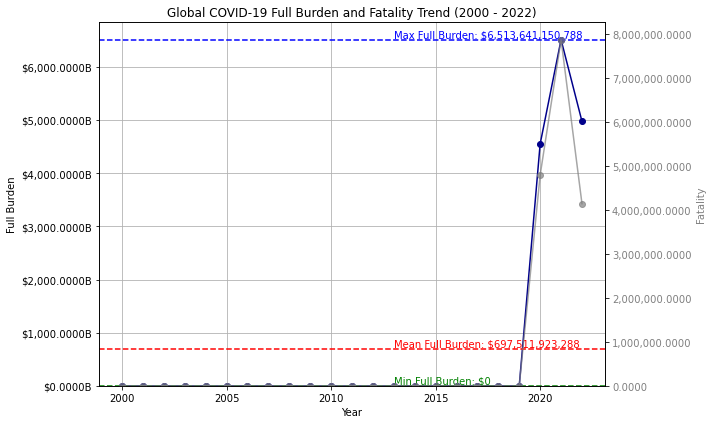

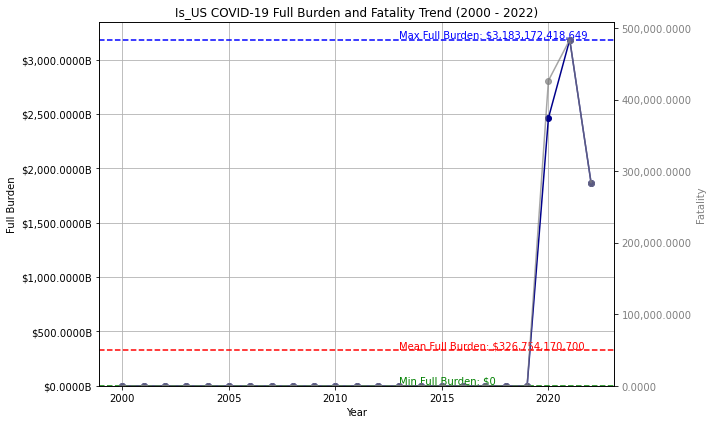

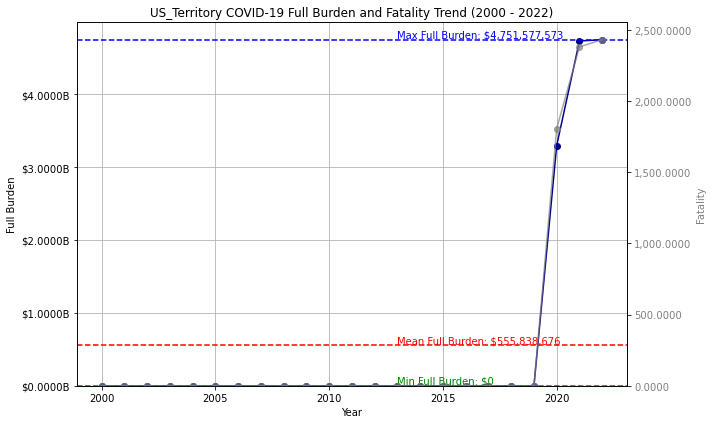

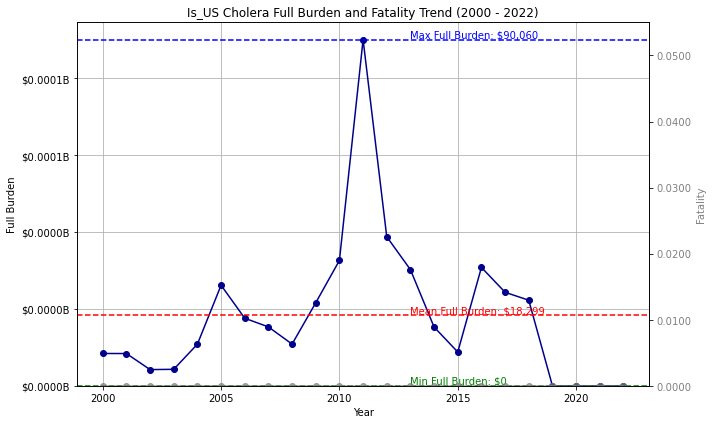

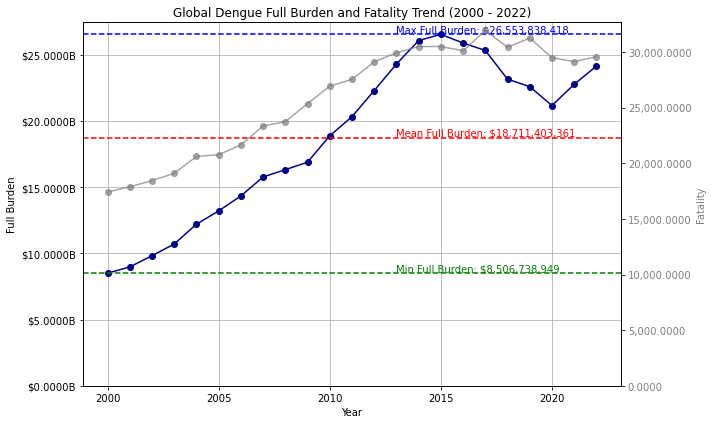

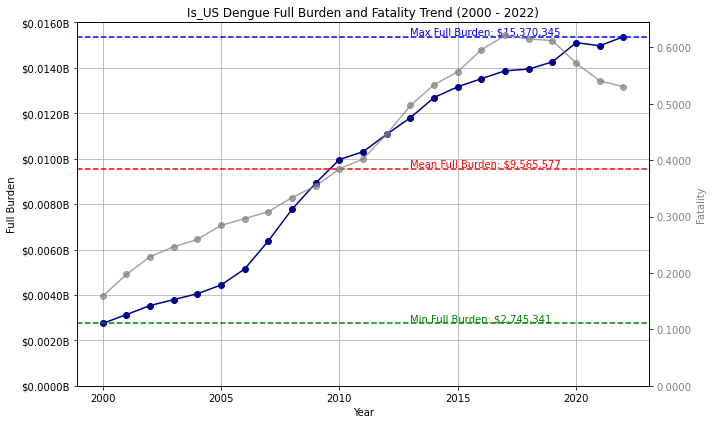

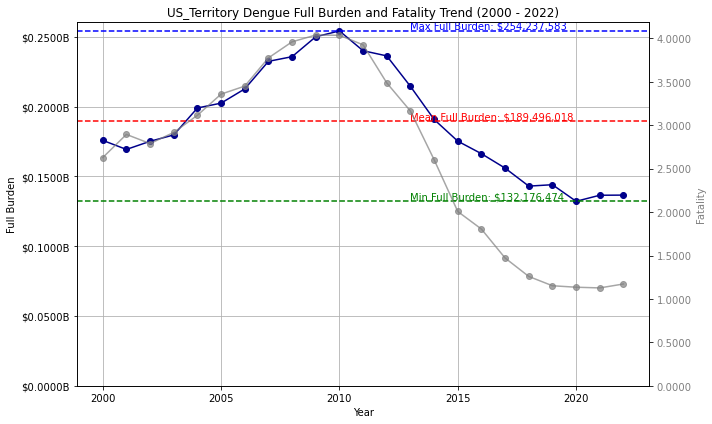

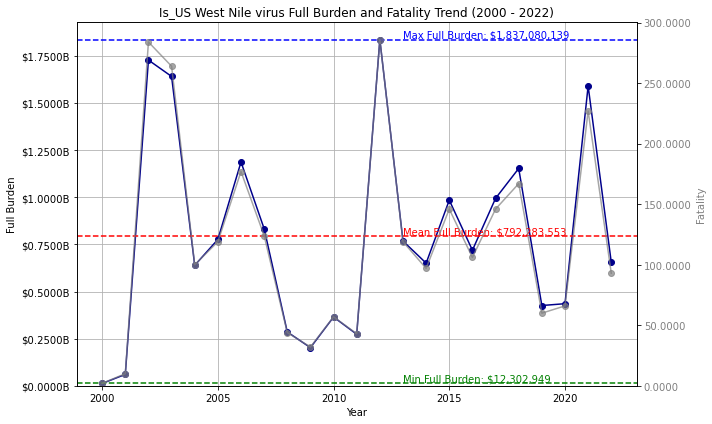

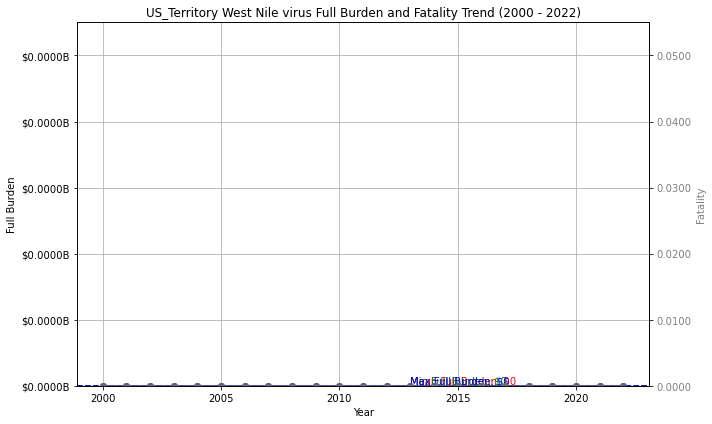

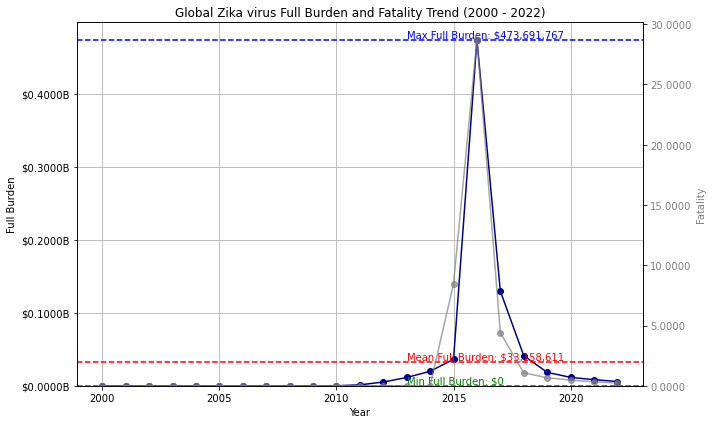

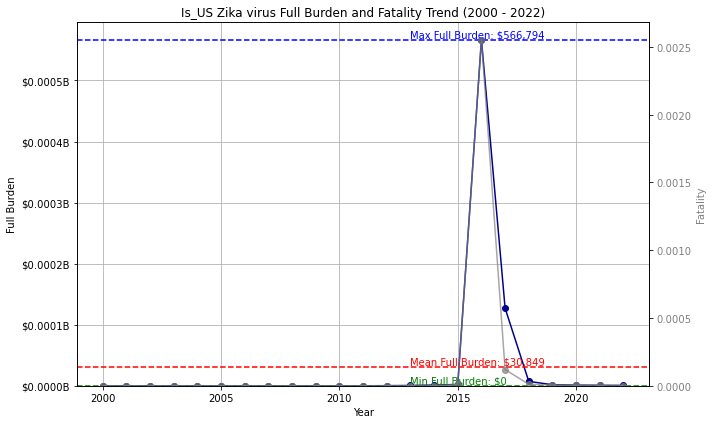

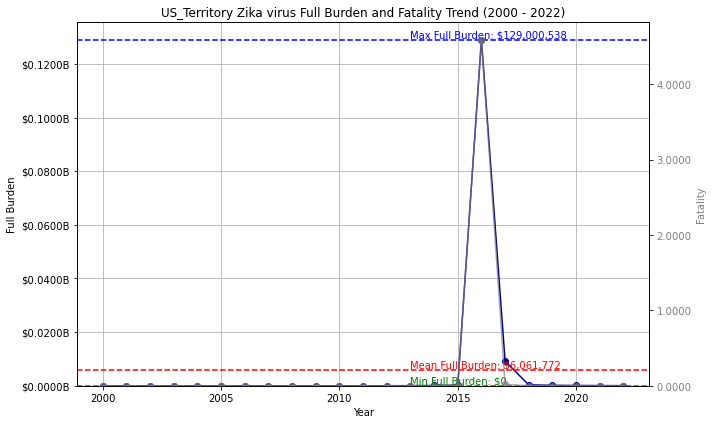

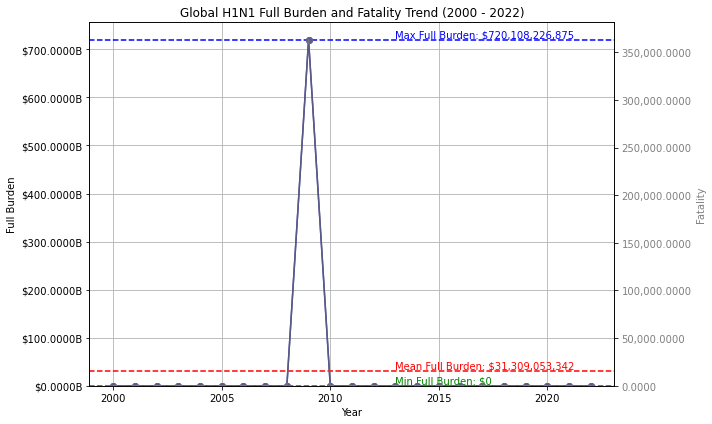

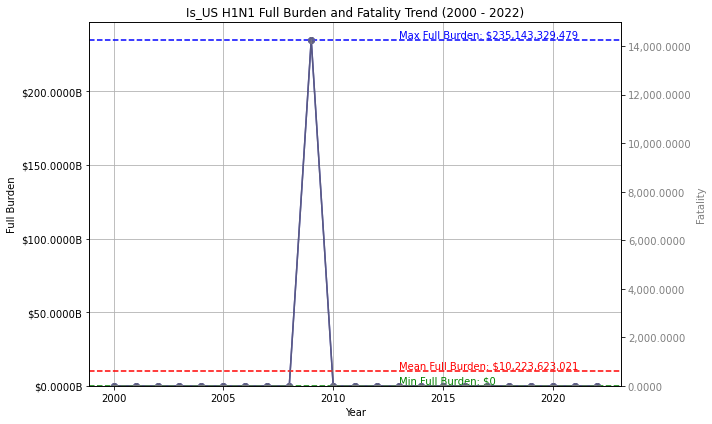

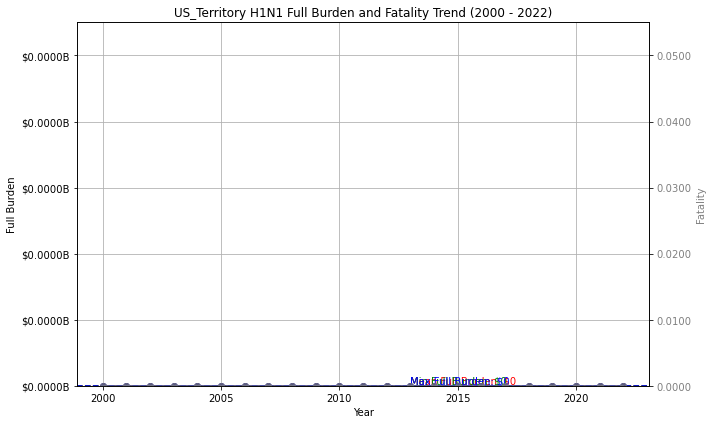

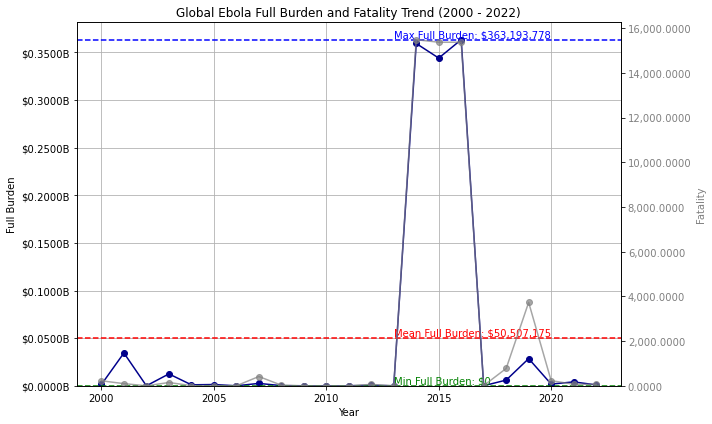

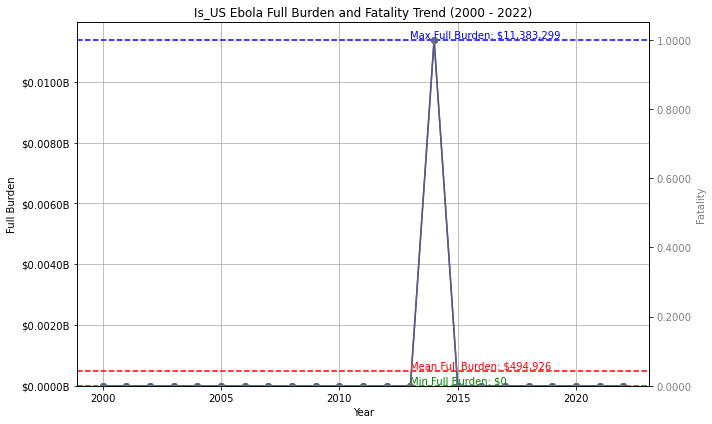

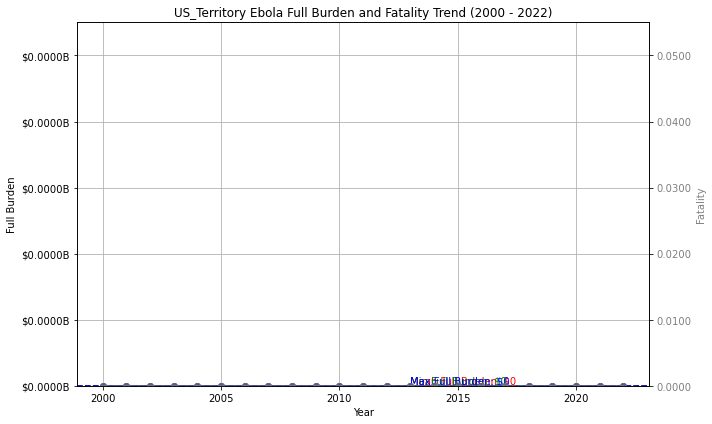

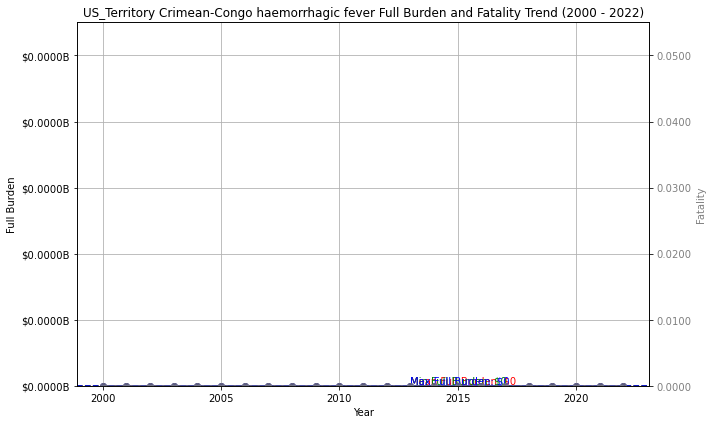

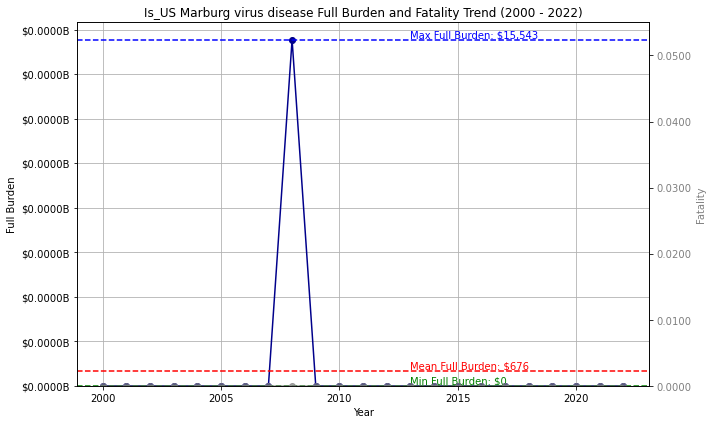

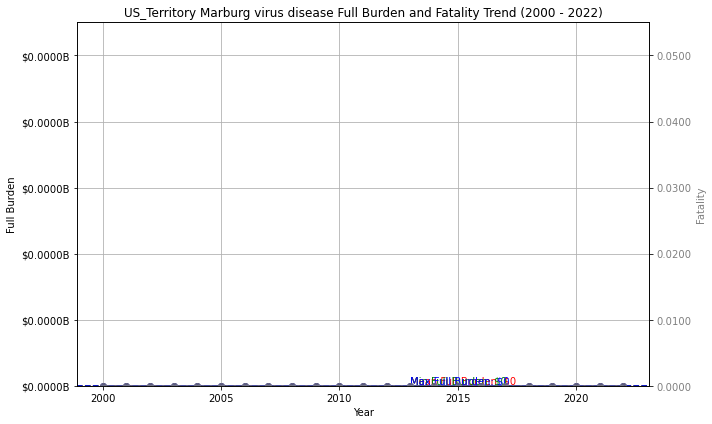

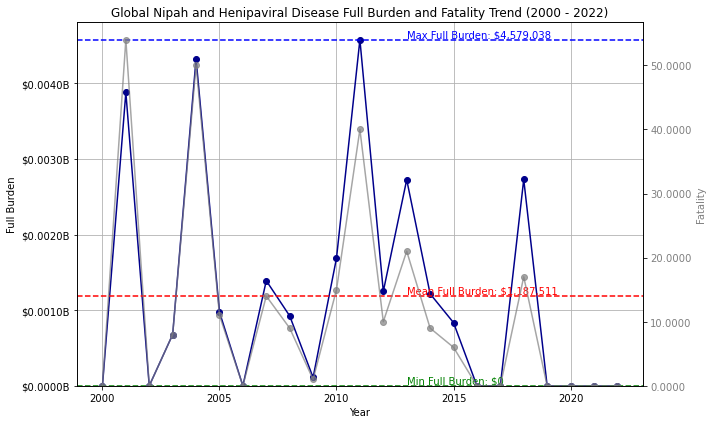

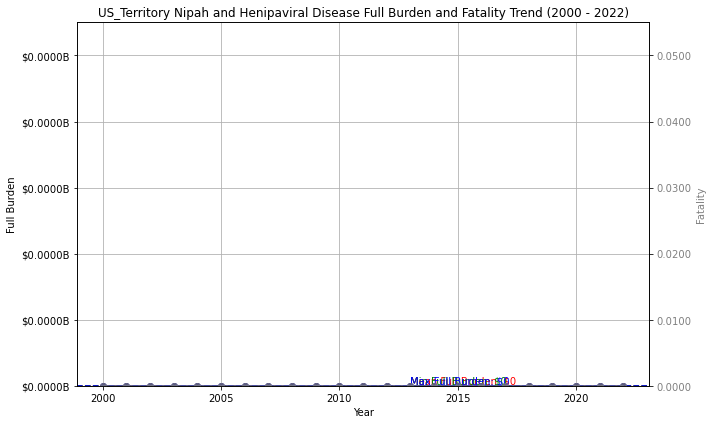

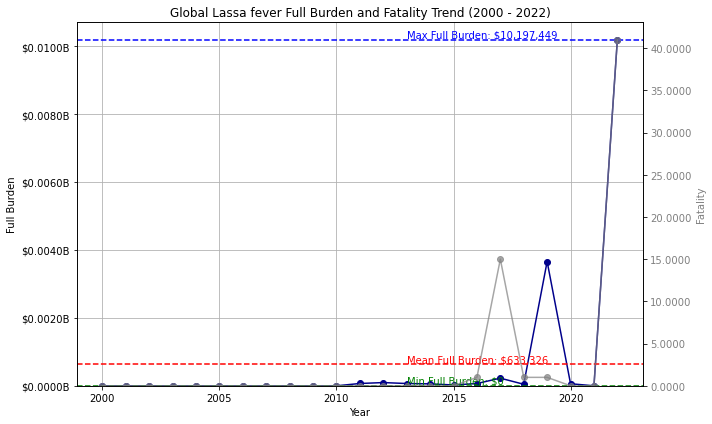

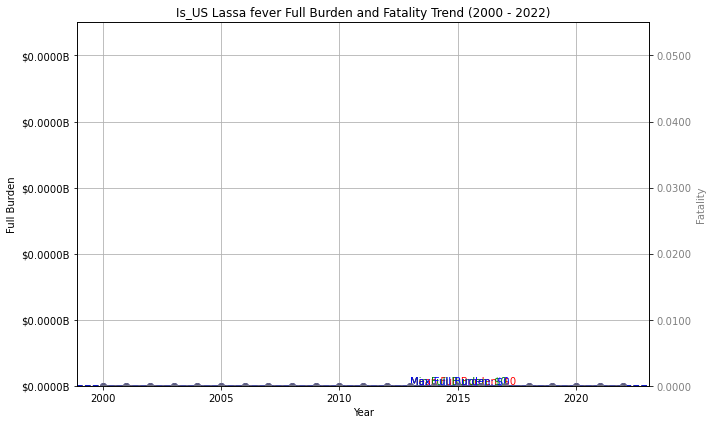

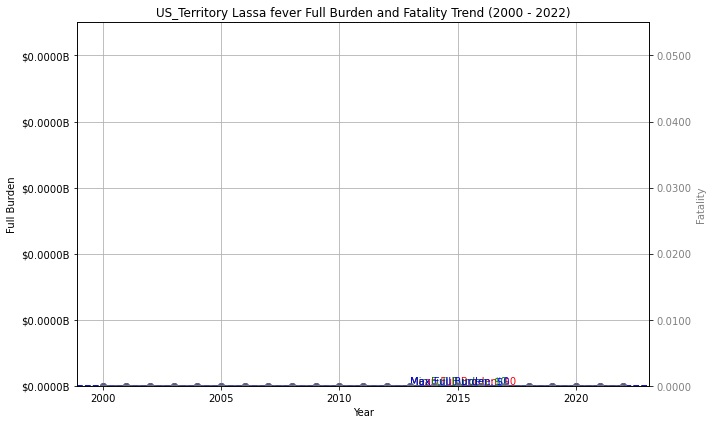

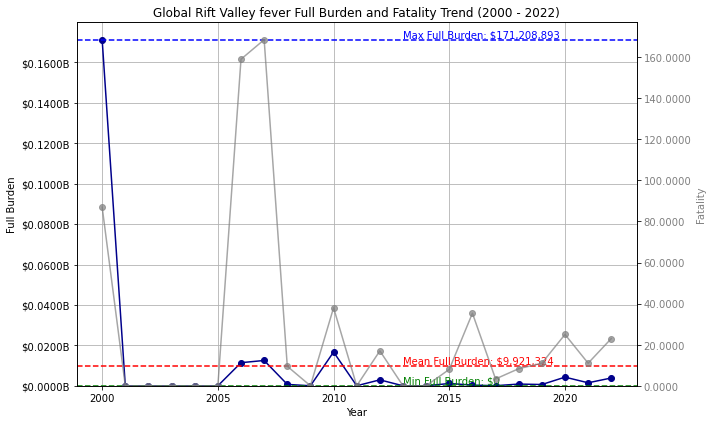

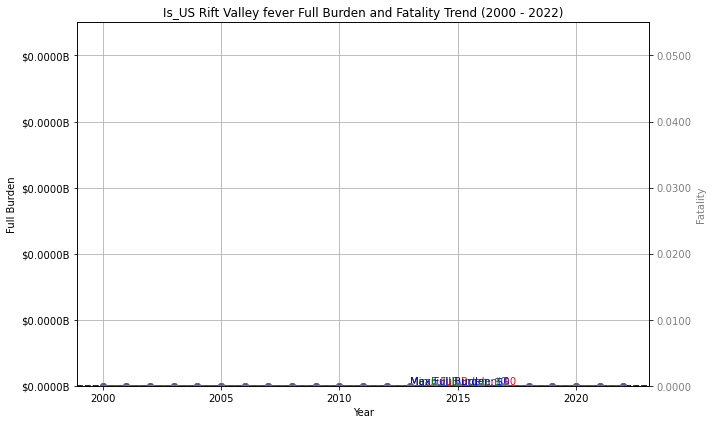

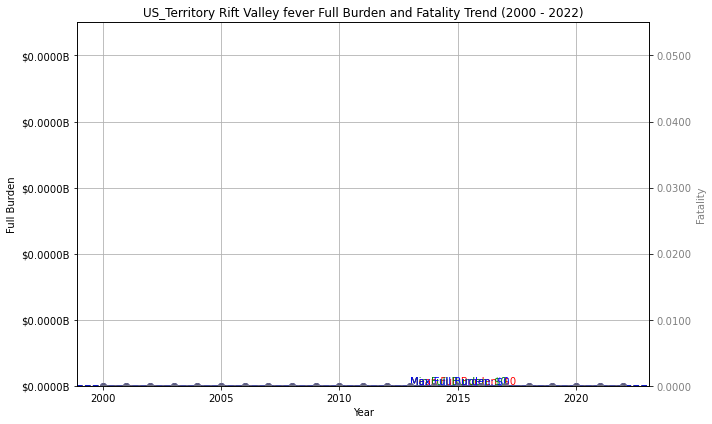

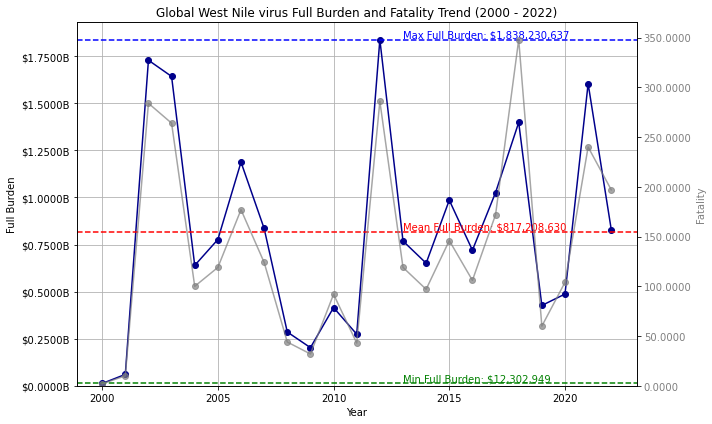

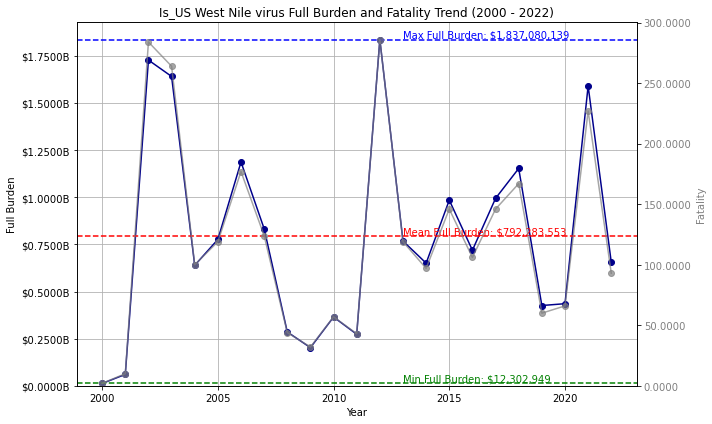

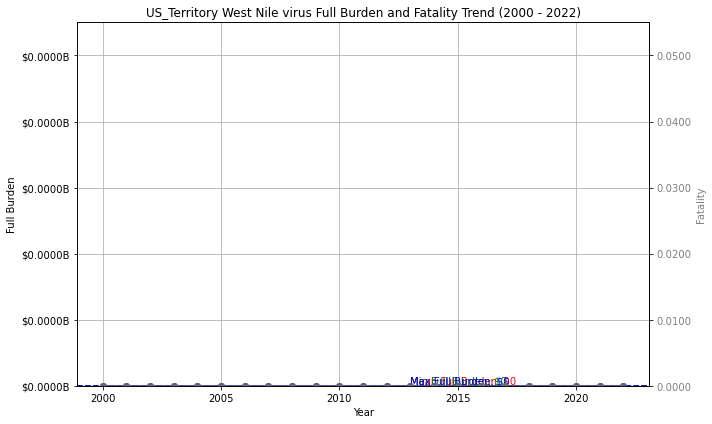

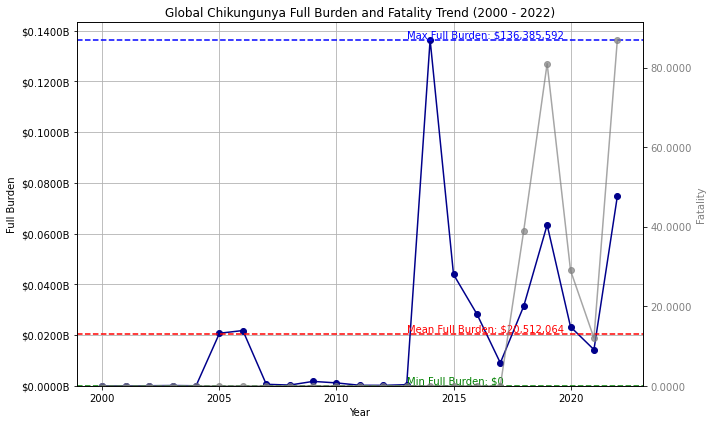

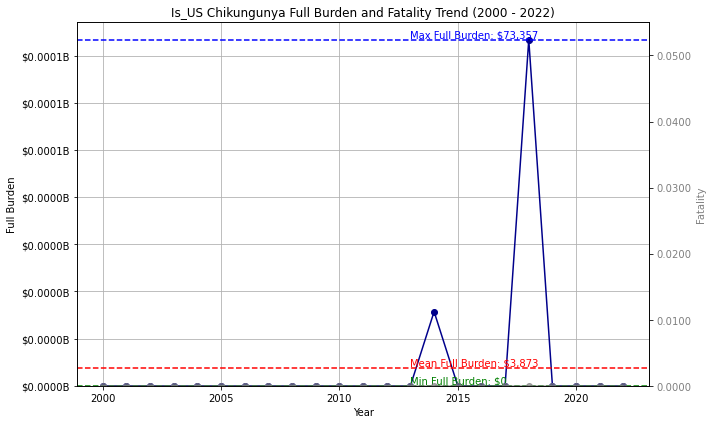

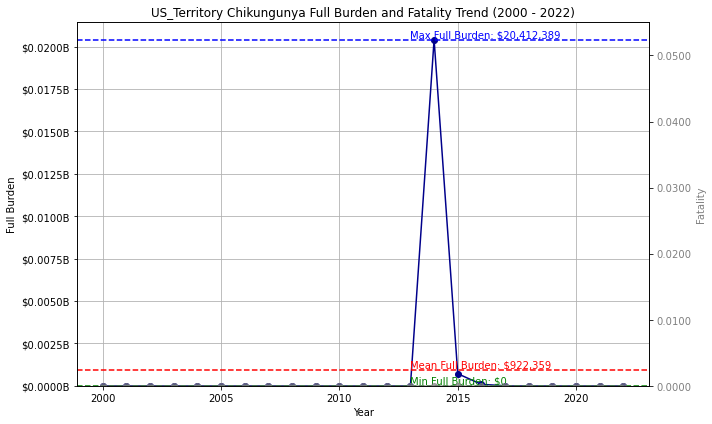

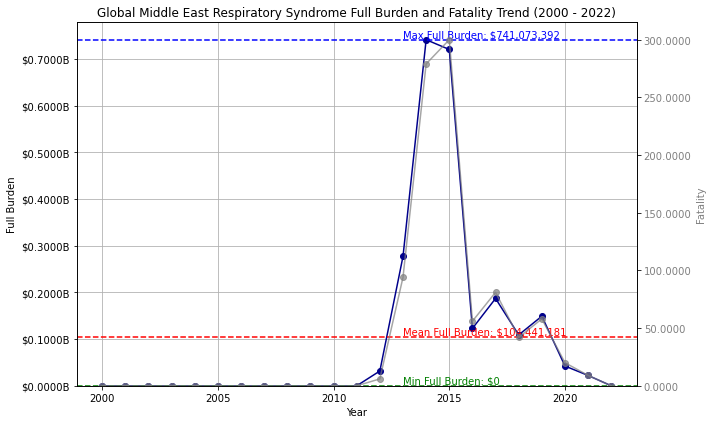

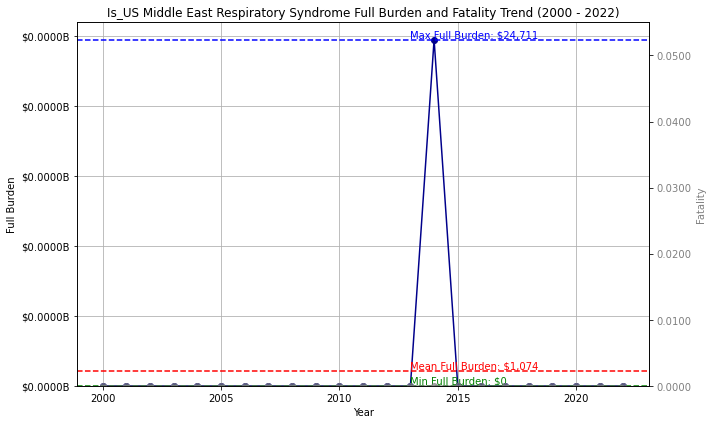

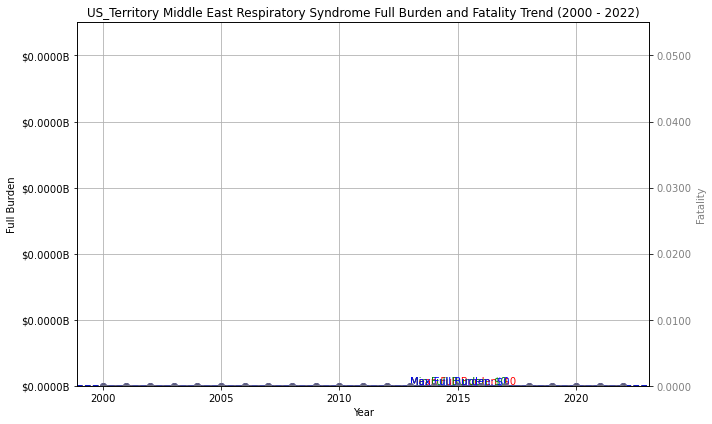

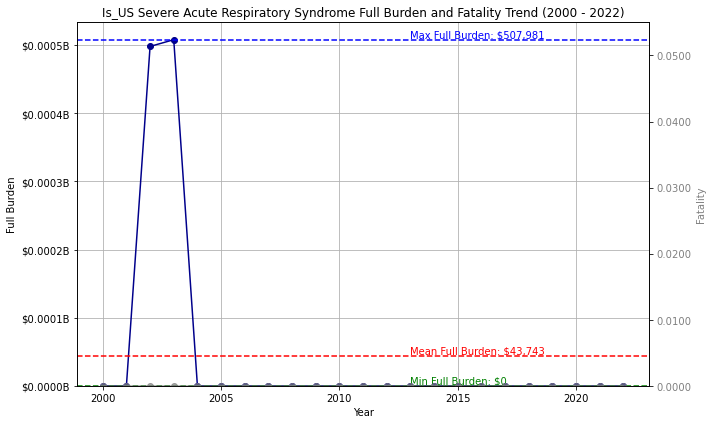

In [20]:
diseases = [
    'COVID-19', 'Cholera', 'Dengue', 'West Nile virus', 'Zika virus', 
    'H1N1', 'Ebola', 'Crimean-Congo haemorrhagic fever', 'Marburg virus disease', 'Nipah and Henipaviral Disease',
    'Lassa fever', 'Rift Valley fever', 'West Nile virus', 'Chikungunya', 'Middle East Respiratory Syndrome','Severe Acute Respiratory Syndrome'
]

def billions_formatter(x, pos):
    return '${:,.4f}B'.format(x / 1e9)

def thousands_formatter(x, pos):
    return '{:,.4f}'.format(x)

with PdfPages('Output/combined_full_burden_fatal_trend_by_disease.pdf') as pdf:
    for disease in diseases:
        for filter_type, filter_condition, label in [('Global', lambda df: df, ''),
                                                     ('Is_US', lambda df: df[df['Is_US'] == 1], '_us'),
                                                     ('US_Territory', lambda df: df[df['US_Territory'] == 1], '_territory')]:
            
            filtered_df = filter_condition(df13[df13['Disease'] == disease])
            
            if disease == 'COVID-19':
                filtered_df_fatal = filtered_df[filtered_df['Year'] <= 2022]
            else:
                filtered_df_fatal = filtered_df
            
            yearly_sum_full_burden = filtered_df.groupby('Year')['Full Burden - All'].sum()
            yearly_sum_fatal = filtered_df_fatal.groupby('Year')['Fatal'].sum()
            
            mean_full_burden = yearly_sum_full_burden.mean()
            min_full_burden = yearly_sum_full_burden.min()
            max_full_burden = yearly_sum_full_burden.max()
            
            plt.figure(figsize=(10, 6))
            
            ax1 = plt.gca()
            ax1.plot(yearly_sum_full_burden.index, yearly_sum_full_burden.values, marker='o', linestyle='-', color='darkblue', label='Full Burden - All')
            ax1.axhline(y=mean_full_burden, color='r', linestyle='--')
            ax1.axhline(y=min_full_burden, color='g', linestyle='--')
            ax1.axhline(y=max_full_burden, color='b', linestyle='--')
            
            ax1.text(x=yearly_sum_full_burden.index[-10], y=mean_full_burden, s=f'Mean Full Burden: ${mean_full_burden:,.0f}', verticalalignment='bottom', color='r')
            ax1.text(x=yearly_sum_full_burden.index[-10], y=min_full_burden, s=f'Min Full Burden: ${min_full_burden:,.0f}', verticalalignment='bottom', color='g')
            ax1.text(x=yearly_sum_full_burden.index[-10], y=max_full_burden, s=f'Max Full Burden: ${max_full_burden:,.0f}', verticalalignment='bottom', color='b')

            ax1.set_title(f'{filter_type} {disease} Full Burden and Fatality Trend (2000 - 2022)')
            ax1.set_xlabel('Year')
            ax1.set_ylabel('Full Burden')
            ax1.grid(True)
            ax1.set_ylim(bottom=0)
            ax1.yaxis.set_major_formatter(FuncFormatter(billions_formatter))
            
            ax2 = ax1.twinx()
            ax2.plot(yearly_sum_fatal.index, yearly_sum_fatal.values, marker='o', linestyle='-', color='grey', label='Fatal', alpha=0.7)
            ax2.set_ylabel('Fatality', color='grey')
            ax2.tick_params(axis='y', labelcolor='grey')
            ax2.set_ylim(bottom=0)
            ax2.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))
            
            plt.tight_layout()
            pdf.savefig() 
            plt.show()

            plt.close()
        

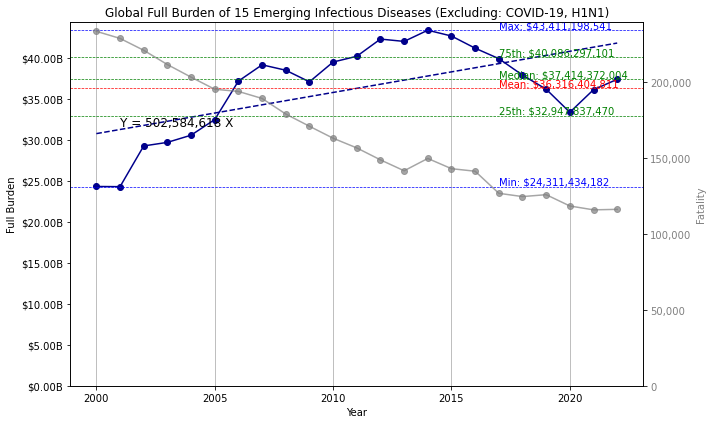

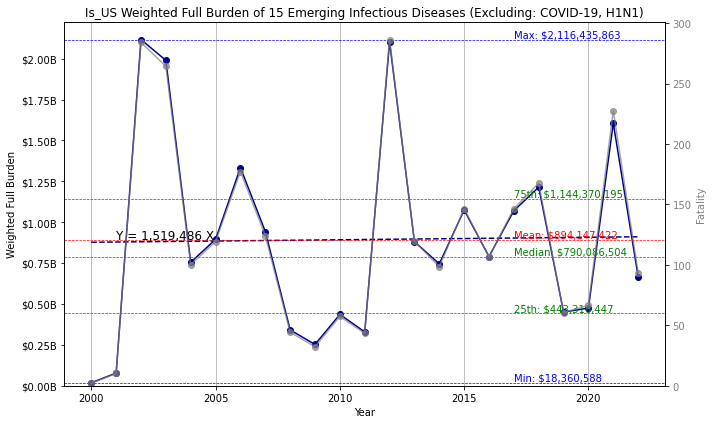

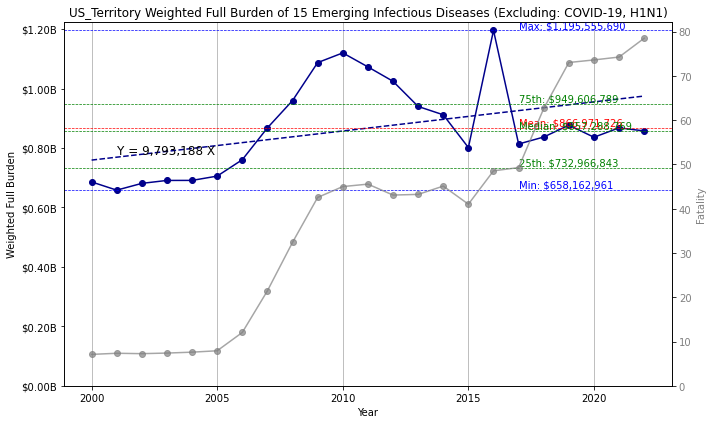

In [21]:
diseases = ['COVID-19', 'H1N1']
diseases_n = ['COVID-19', 'H1N1']

def billions_formatter(x, pos):
    return '${:,.2f}B'.format(x / 1e9)

def thousands_formatter(x, pos):
    return '{:,.0f}'.format(x)

excluded_diseases = ', '.join(diseases)
excluded_diseases_n = ', '.join(diseases_n)

filename = f'Output/combined_full_burden_fatal_trend_by_year_excluding_{excluded_diseases.replace(", ", "_")}.pdf'

metrics = ['Full Burden - All', 'Weighted Full Burden - All']
labels = ['Full Burden', 'Weighted Full Burden']

with PdfPages(filename) as pdf:
    for metric, label in zip(metrics, labels):
        for filter_type, filter_condition, suffix in [('Global', lambda df: df, ''),
                                                      ('Is_US', lambda df: df[df['Is_US'] == 1], '_us'),
                                                      ('US_Territory', lambda df: df[df['US_Territory'] == 1], '_territory')]:
            
            filtered_df = filter_condition(df13[~df13['Disease'].isin(diseases)])
            yearly_sum_burden = filtered_df.groupby('Year')[metric].sum()
            yearly_sum_fatal = filtered_df.groupby('Year')['Fatal'].sum()

            mean_burden = yearly_sum_burden.mean()
            min_burden = yearly_sum_burden.min()
            max_burden = yearly_sum_burden.max()

            p25 = np.percentile(yearly_sum_burden, 25)
            p50 = np.percentile(yearly_sum_burden, 50)
            p75 = np.percentile(yearly_sum_burden, 75)

            slope, intercept, _, _, _ = linregress(yearly_sum_burden.index.astype(float), yearly_sum_burden.values)
            trend_line = intercept + slope * yearly_sum_burden.index.astype(float)

            plt.figure(figsize=(10, 6))
            ax1 = plt.gca()

            ax1.plot(yearly_sum_burden.index, yearly_sum_burden.values, marker='o', linestyle='-', color='darkblue', label=f'{label} - All')
            ax1.plot(yearly_sum_burden.index, trend_line, 'darkblue', linestyle='--', label=f'{label} Trend Line')

            trend_eq = f'Y = {slope:,.0f} X'
            ax1.text(x=yearly_sum_burden.index[1], y=trend_line[1], s=trend_eq, color='black', fontsize=12, verticalalignment='bottom')

            ax1.axhline(y=mean_burden, color='r', linestyle='--', linewidth=0.7)
            ax1.axhline(y=min_burden, color='b', linestyle='--', linewidth=0.7)
            ax1.axhline(y=max_burden, color='b', linestyle='--', linewidth=0.7)
            ax1.axhline(y=p25, color='g', linestyle='--', label='25th Percentile', linewidth=0.7)
            ax1.axhline(y=p50, color='g', linestyle='--', label='Median (50th Percentile)', linewidth=0.7)
            ax1.axhline(y=p75, color='g', linestyle='--', label='75th Percentile', linewidth=0.7)

            ax1.text(x=yearly_sum_burden.index[-6], y=mean_burden, s=f'Mean: ${mean_burden:,.0f}', verticalalignment='bottom', color='r')
            ax1.text(x=yearly_sum_burden.index[-6], y=min_burden, s=f'Min: ${min_burden:,.0f}', verticalalignment='bottom', color='b')
            ax1.text(x=yearly_sum_burden.index[-6], y=max_burden, s=f'Max: ${max_burden:,.0f}', verticalalignment='bottom', color='b')
            ax1.text(x=yearly_sum_burden.index[-6], y=p25, s=f'25th: ${p25:,.0f}', verticalalignment='bottom', color='g')
            ax1.text(x=yearly_sum_burden.index[-6], y=p50, s=f'Median: ${p50:,.0f}', verticalalignment='bottom', color='g')
            ax1.text(x=yearly_sum_burden.index[-6], y=p75, s=f'75th: ${p75:,.0f}', verticalalignment='bottom', color='g')

            ax1.set_title(f'{filter_type} {label} of 15 Emerging Infectious Diseases (Excluding: {excluded_diseases_n})')
            ax1.set_xlabel('Year')
            ax1.set_ylabel(label)
            ax1.grid(True, axis='x')
            ax1.set_ylim(bottom=0)
            ax1.yaxis.set_major_formatter(FuncFormatter(billions_formatter))

            ax2 = ax1.twinx()
            ax2.plot(yearly_sum_fatal.index, yearly_sum_fatal.values, marker='o', linestyle='-', color='grey', label='Fatal', alpha=0.7)
            ax2.set_ylabel('Fatality', color='grey')
            ax2.tick_params(axis='y', labelcolor='grey')
            ax2.set_ylim(bottom=0)
            ax2.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

            plt.tight_layout()
            pdf.savefig()
            plt.show()
            plt.close()


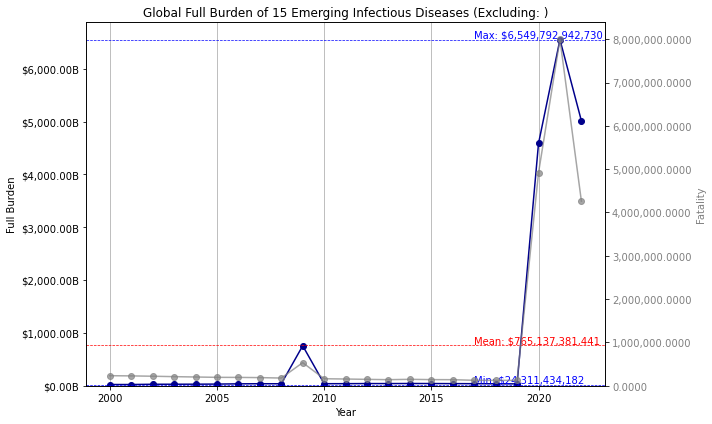

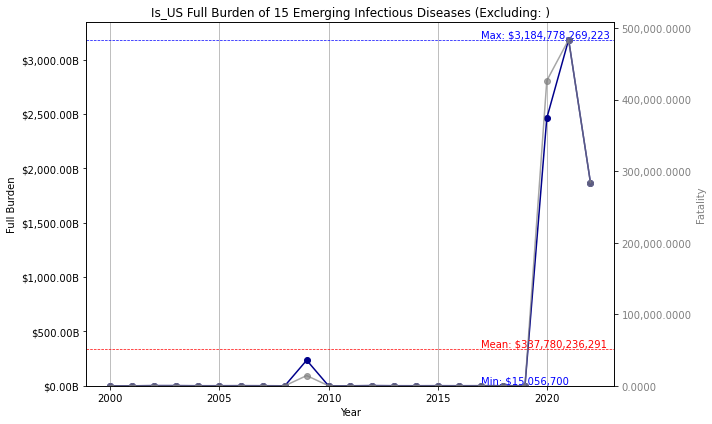

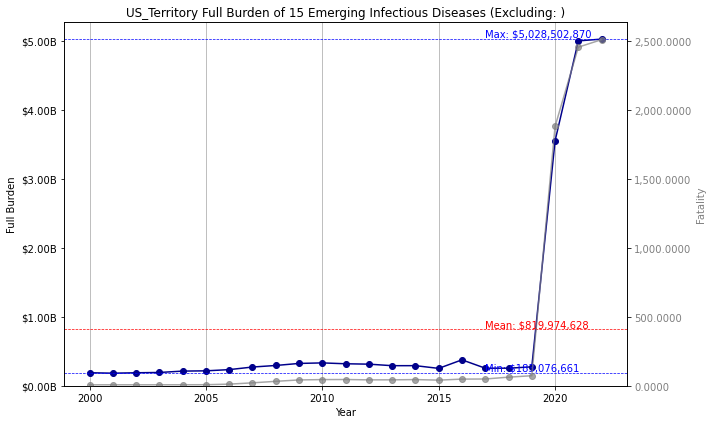

In [22]:
diseases = []
diseases_n = []

def billions_formatter(x, pos):
    return '${:,.2f}B'.format(x / 1e9)

def thousands_formatter(x, pos):
    return '{:,.4f}'.format(x)

excluded_diseases = ', '.join(diseases)
excluded_diseases_n = ', '.join(diseases_n)

filename = f'Output/combined_full_burden_fatal_trend_by_year_excluding_{excluded_diseases.replace(", ", "_")}.pdf'

with PdfPages(filename) as pdf:
    for filter_type, filter_condition, label in [('Global', lambda df: df, ''),
                                                 ('Is_US', lambda df: df[df['Is_US'] == 1], '_us'),
                                                 ('US_Territory', lambda df: df[df['US_Territory'] == 1], '_territory')]:
        
        filtered_df = filter_condition(df13[~df13['Disease'].isin(diseases)])
        yearly_sum_full_burden = filtered_df.groupby('Year')['Full Burden - All'].sum()
        yearly_sum_fatal = filtered_df.groupby('Year')['Fatal'].sum()

        mean_full_burden = yearly_sum_full_burden.mean()
        min_full_burden = yearly_sum_full_burden.min()
        max_full_burden = yearly_sum_full_burden.max()

        p25 = np.percentile(yearly_sum_full_burden, 25)
        p50 = np.percentile(yearly_sum_full_burden, 50)
        p75 = np.percentile(yearly_sum_full_burden, 75)

        plt.figure(figsize=(10, 6))
        ax1 = plt.gca()

        ax1.plot(yearly_sum_full_burden.index, yearly_sum_full_burden.values, marker='o', linestyle='-', color='darkblue', label='Full Burden - All')

        ax1.axhline(y=mean_full_burden, color='r', linestyle='--', linewidth=0.7)
        ax1.axhline(y=min_full_burden, color='b', linestyle='--', linewidth=0.7)
        ax1.axhline(y=max_full_burden, color='b', linestyle='--', linewidth=0.7)
      
        ax1.text(x=yearly_sum_full_burden.index[-6], y=mean_full_burden, s=f'Mean: ${mean_full_burden:,.0f}', verticalalignment='bottom', color='r')
        ax1.text(x=yearly_sum_full_burden.index[-6], y=min_full_burden, s=f'Min: ${min_full_burden:,.0f}', verticalalignment='bottom', color='b')
        ax1.text(x=yearly_sum_full_burden.index[-6], y=max_full_burden, s=f'Max: ${max_full_burden:,.0f}', verticalalignment='bottom', color='b')
      
        ax1.set_title(f'{filter_type} Full Burden of 15 Emerging Infectious Diseases (Excluding: {excluded_diseases_n})')
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Full Burden')
        ax1.grid(True, axis='x')
        ax1.set_ylim(bottom=0)
        ax1.yaxis.set_major_formatter(FuncFormatter(billions_formatter))

        ax2 = ax1.twinx()
        ax2.plot(yearly_sum_fatal.index, yearly_sum_fatal.values, marker='o', linestyle='-', color='grey', label='Fatal', alpha=0.7)
        ax2.set_ylabel('Fatality', color='grey')
        ax2.tick_params(axis='y', labelcolor='grey')
        ax2.set_ylim(bottom=0)
        ax2.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

        plt.tight_layout()
        pdf.savefig()
        plt.show()
        plt.close()



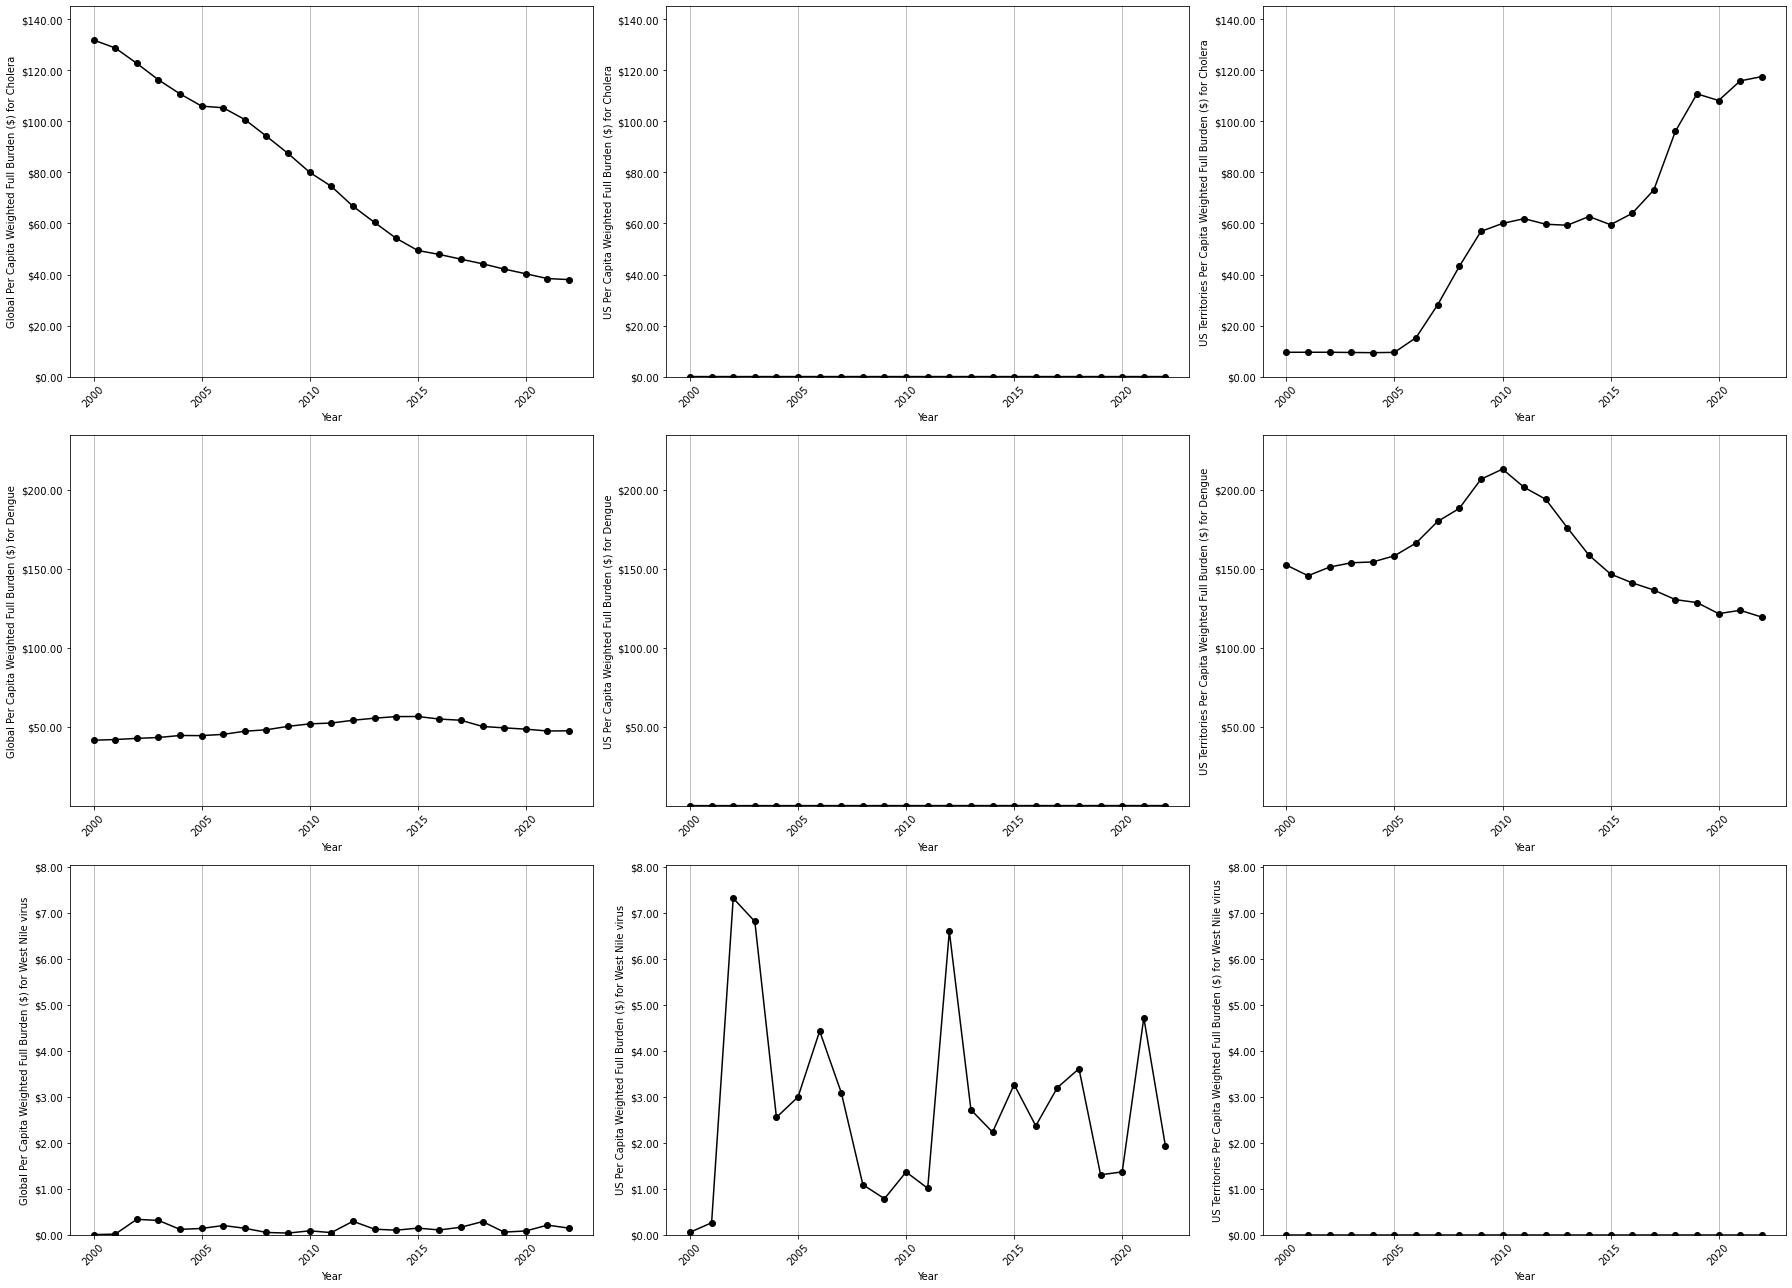

In [23]:
diseases = ['Cholera', 'Dengue', 'West Nile virus']

with PdfPages('Output/combined_pc_weighted_full_burden_fatal_trend_by_disease.pdf') as pdf:
    fig, axes = plt.subplots(3, 3, figsize=(25, 18))  

    for disease_idx, disease in enumerate(diseases):
        all_yearly_per_capita_values = []

        for filter_type, filter_condition, label in [('Global', lambda df: df, ''),
                                                     ('Is_US', lambda df: df[df['Is_US'] == 1], '_us'),
                                                     ('US_Territory', lambda df: df[df['US_Territory'] == 1], '_territory')]:

            filtered_df = filter_condition(df13[df13['Disease'] == disease])
            yearly_sum_full_burden = filtered_df.groupby('Year')['Weighted Full Burden - All'].sum()
            yearly_sum_population  = filtered_df.groupby('Year')['Population'].sum()
            yearly_per_capita = yearly_sum_full_burden / yearly_sum_population

            all_yearly_per_capita_values.extend(yearly_per_capita.values)

        min_value = min(all_yearly_per_capita_values)
        max_value = max(all_yearly_per_capita_values)

        for i, (filter_type, filter_condition, label) in enumerate([('Global', lambda df: df, ''),
                                                                    ('Is_US', lambda df: df[df['Is_US'] == 1], '_us'),
                                                                    ('US_Territory', lambda df: df[df['US_Territory'] == 1], '_territory')]):

            filtered_df = filter_condition(df13[df13['Disease'] == disease])
            yearly_sum_full_burden = filtered_df.groupby('Year')['Weighted Full Burden - All'].sum()
            yearly_sum_population  = filtered_df.groupby('Year')['Population'].sum()
            yearly_per_capita = yearly_sum_full_burden / yearly_sum_population
            
            ax = axes[disease_idx, i]  
            ax.plot(yearly_per_capita.index, yearly_per_capita.values, marker='o', linestyle='-', color='black', label='Full Burden - All')

            ylabel = filter_type
            if filter_type == 'Is_US':
                ylabel = 'US'
            elif filter_type == 'US_Territory':
                ylabel = 'US Territories'

            ax.set_xlabel('Year')
            ax.set_ylabel(f'{ylabel} Per Capita Weighted Full Burden ($) for {disease}')

            ax.grid(True, axis='x')

            ax.set_ylim(min_value, 1.1 * max_value)

            years = yearly_per_capita.index
            every_two_years = np.arange(min(years), max(years) + 1, 5)

            ax.set_xticks(every_two_years)
            ax.set_xticklabels(every_two_years, rotation=45)

            ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: f'${x:,.2f}'))

    plt.tight_layout()
    pdf.savefig(fig)
    plt.show()

    plt.close()


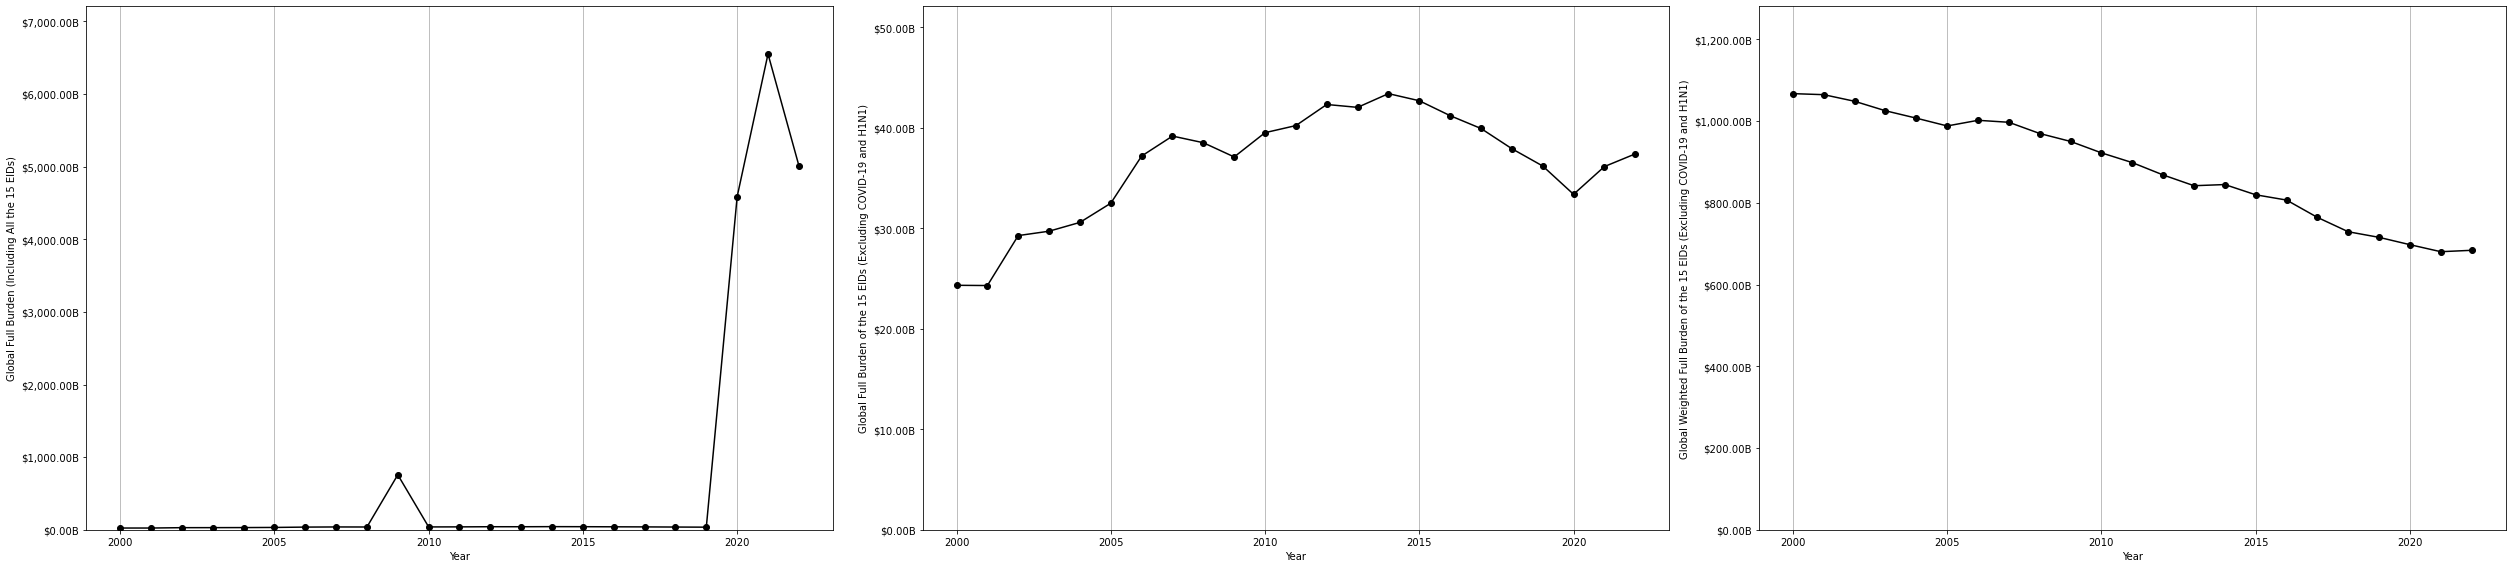

In [24]:
diseases = ['COVID-19', 'H1N1']
diseases_n = ['COVID-19', 'H1N1']

def billions_formatter(x, pos):
    return '${:,.2f}B'.format(x / 1e9)

def thousands_formatter(x, pos):
    return '{:,.0f}'.format(x)

excluded_diseases = ', '.join(diseases)
excluded_diseases_n = ', '.join(diseases_n)

filename = f'Output/combined_global_full_burden_fatal_trend_by_year_excluding_{excluded_diseases.replace(", ", "_")}.pdf'

metrics = ['Full Burden - All', 'Weighted Full Burden - All']
labels = ['Full Burden', 'Weighted Full Burden']

with PdfPages(filename) as pdf:
    
    fig, axes = plt.subplots(1, 3, figsize=(35, 8))  

    ax1 = axes[0]  
    filtered_df = df13
    yearly_sum_burden = filtered_df.groupby('Year')['Full Burden - All'].sum()

    max_burden = yearly_sum_burden.max() * 1.1

    ax1.plot(yearly_sum_burden.index, yearly_sum_burden.values, marker='o', linestyle='-', color='black', label='Full Burden - All')

    ax1.set_xlabel('Year')
    ax1.set_ylabel('Global Full Burden (Including All the 15 EIDs)')
    ax1.grid(True, axis='x')
    ax1.set_ylim(bottom=0, top=max_burden)  
    ax1.yaxis.set_major_formatter(FuncFormatter(billions_formatter))

    for idx, (metric, label) in enumerate(zip(metrics, labels), start=1):  
        
        filtered_df = df13[~df13['Disease'].isin(diseases)]
        yearly_sum_burden = filtered_df.groupby('Year')[metric].sum()

        max_burden = yearly_sum_burden.max() * 1.2  

        ax1 = axes[idx]  

        ax1.plot(yearly_sum_burden.index, yearly_sum_burden.values, marker='o', linestyle='-', color='black', label=f'{label} - All')

        ax1.set_xlabel('Year')
        ax1.set_ylabel(f'Global {label} of the 15 EIDs (Excluding COVID-19 and H1N1)')
        ax1.grid(True, axis='x')
        ax1.set_ylim(bottom=0, top=max_burden)  
        ax1.yaxis.set_major_formatter(FuncFormatter(billions_formatter))

    plt.tight_layout()
    pdf.savefig(fig)  
    plt.show()
    plt.close()


# Monte-Carlo-Simulations
In this section, we perform Monte Carlo simulations through the following steps:

- Calculate adjustment factors for Dengue and ONTD diseases using IHME projections.
- Define Coronavirus as a family of diseases including MERS, SARS, and COVID-19.
- Define pandemic flu as a combination of H1N1 and COVID-19.
- Construct simulation scenarios for all diseases over a 10-year period.
- Adjust random years for Coronavirus, Zika, Ebola, and pandemic flu to reflect the natural progression of these diseases.
- Expand random draws to encompass all countries in the dataset.
- Extract burden and population data from historical tables.
- Adjust Dengue and ONTD burden estimates using ratios derived from IHME projections (adjusted burdens).
- Apply growth rates and discount factors to calculate discounted adjusted burdens.
- Aggregate results across geographic regions, simulation draws, and Emerging Infectious Diseases (EIDs).


In [25]:
# Adjustment Factors for Monte Carlo Simulations

# Dengue Factors

dengue_all.loc[dengue_all['Location']   == 'Russian Federation', 'Location'] = 'Russia'
dengue_all.loc[dengue_all['Location']   == 'Macedonia', 'Location'] = 'North Macedonia'
dengue_all.loc[dengue_all['Location']   == 'Swaziland', 'Location'] = 'Eswatini'


dengue_all_death                       = dengue_all[
                                        (dengue_all['Measure'] == 'Deaths') & 
                                        (dengue_all['Unit'] == 'Number') & 
                                        ((dengue_all['Forecast Scenario'] == 'Reference') | (dengue_all['Forecast Scenario'] == 'Past estimate'))
]

unique_countries                       = df12['Country'].unique()
dengue_all_death                       = dengue_all_death[dengue_all_death['Location'].isin(unique_countries)]

def calculate_avg_and_ratio_dengue(group):
    avg_2000_2022                      = group[group['Year'] < 2023]['Value'].mean()
    group['AVG_2000_2022']             = avg_2000_2022
    group['Dengue - Ratio']            = group['Value'] / avg_2000_2022
    return group

dengue_all_death                       = dengue_all_death.groupby('Location').apply(calculate_avg_and_ratio_dengue)

dengue_factors                         = dengue_all_death[['Location', 'Year', 'Dengue - Ratio']].copy()
dengue_factors.columns                 = ['Location', 'Year', 'Dengue - Ratio']
dengue_factors                         = dengue_factors[(dengue_factors['Year'] >= 2025) & (dengue_factors['Year'] <= 2034)]


# ONTD Factors

# DENGUE
ontd_all.loc[ontd_all['Location']   == 'Russian Federation', 'Location'] = 'Russia'
ontd_all.loc[ontd_all['Location']   == 'Macedonia', 'Location'] = 'North Macedonia'
ontd_all.loc[ontd_all['Location']   == 'Swaziland', 'Location'] = 'Eswatini'


ontd_all_death                         = ontd_all[
                                        (ontd_all['Measure'] == 'Deaths') & 
                                        (ontd_all['Unit'] == 'Number') & 
                                        ((ontd_all['Forecast Scenario'] == 'Reference') | (ontd_all['Forecast Scenario'] == 'Past estimate'))
]

unique_countries                       = df12['Country'].unique()
ontd_all_death                         = ontd_all_death[ontd_all_death['Location'].isin(unique_countries)]

def calculate_avg_and_ratio_ontd(group):
    avg_2000_2022                      = group[group['Year'] < 2023]['Value'].mean()
    group['AVG_2000_2022']             = avg_2000_2022
    if avg_2000_2022                   == 0:
        group['ONTD - Ratio']          = 1
    else:
        group['ONTD - Ratio']          = group['Value'] / avg_2000_2022
    return group

ontd_all_death                         = ontd_all_death.groupby('Location').apply(calculate_avg_and_ratio_ontd)

ontd_factors                           = ontd_all_death[['Location', 'Year', 'ONTD - Ratio']].copy()
ontd_factors.columns                   = ['Location', 'Year', 'ONTD - Ratio']
ontd_factors                           = ontd_factors[(ontd_factors['Year'] >= 2025) & (ontd_factors['Year'] <= 2034)]

In [27]:
columns_to_keep                        = ["Country", "Disease", "Year", "Fatal","Full Burden - All", "Weighted Full Burden - All","Population"]
df15                                   = df13[columns_to_keep].copy()
df15                                   = df15.drop_duplicates()

df_corona_virus                        = df15[df15['Disease'] == 'COVID-19']

fatal_sum                              = df_corona_virus[df_corona_virus['Year'].isin([2020, 2021, 2022])]['Fatal'].sum()
population_ratio                       = df_corona_virus[df_corona_virus['Year'] == 2020]['Population'].sum() / 1900000000
standardization_factor                 = (8.75 / (fatal_sum/1000000)) * population_ratio

# Define Pandemic Flu Disease as the combination of H1N1 and COVID-19
h1n1_rows                              = df15[df15['Disease'] == 'H1N1'].copy()
h1n1_rows['Disease']                   = 'Pandemic Flu'
df15                                   = pd.concat([df15, h1n1_rows], ignore_index=True)

pandemic_flu_rows = df15[df15['Disease'] == 'Pandemic Flu'].copy()

new_rows = []

for country in pandemic_flu_rows['Country'].unique():
    
    covid_rows = df15[(df15['Country'] == country) & 
                      (df15['Disease'] == 'COVID-19') & 
                      (df15['Year'].isin([2020, 2021, 2022]))]
    
    if not covid_rows.empty:
        
        full_burden_1918 = 0.86 * standardization_factor * covid_rows['Full Burden - All'].sum()
        weighted_full_burden_1918 = 0.86 * standardization_factor * covid_rows['Weighted Full Burden - All'].sum()
        population_1918 = covid_rows[covid_rows['Year'] == 2020]['Population'].values[0]
        
        new_rows.append({
            'Country': country,
            'Disease': 'Pandemic Flu',
            'Year': 1918,
            'Full Burden - All': full_burden_1918,
            'Weighted Full Burden - All': weighted_full_burden_1918,
            'Population': population_1918
        })
        
        full_burden_1919 = 0.14 * standardization_factor * covid_rows['Full Burden - All'].sum()
        weighted_full_burden_1919 = 0.14 * standardization_factor * covid_rows['Weighted Full Burden - All'].sum()
        population_1919 = covid_rows[covid_rows['Year'] == 2020]['Population'].values[0]
        
        new_rows.append({
            'Country': country,
            'Disease': 'Pandemic Flu',
            'Year': 1919,
            'Full Burden - All': full_burden_1919,
            'Weighted Full Burden - All': weighted_full_burden_1919,
            'Population': population_1919
        })
        
    
new_rows_df = pd.DataFrame(new_rows)

df15 = pd.concat([df15, new_rows_df], ignore_index=True)

df15.to_excel('Output/df15.xlsx', index=False)

# Define Coronavirus Group
corona_viruses                         = ['COVID-19', 'Middle East Respiratory Syndrome', 'Severe Acute Respiratory Syndrome']
df15['Disease_Grouped']                = df15['Disease'].apply(lambda x: 'Coronavirus' if x in corona_viruses else x)

df16                                   = df15.groupby(['Country','Disease_Grouped','Year']).agg({
                                            'Full Burden - All': 'sum',
                                            'Weighted Full Burden - All': 'sum',
                                            'Population':'mean'
                                        }).reset_index()

df16.to_excel('Output/df16.xlsx', index=False)

In [28]:
np.random.seed(42)
n                                      = 5000
discount_rates                         = [0.03]

dengue_factors_wide                    = dengue_factors.pivot(index='Location', columns='Year', values='Dengue - Ratio')

dengue_factors_wide.reset_index(inplace=True)
dengue_factors_wide.columns            = ['Location'] + [f'Dengue - Ratio {col}' for col in dengue_factors_wide.columns[1:]]

ontd_factors_wide                      = ontd_factors.pivot(index='Location', columns='Year', values='ONTD - Ratio')

ontd_factors_wide.reset_index(inplace=True)
ontd_factors_wide.columns              = ['Location'] + [f'ONTD - Ratio {col}' for col in ontd_factors_wide.columns[1:]]

In [29]:

diseases = [
    'Crimean-Congo haemorrhagic fever', 'Marburg virus disease', 'Lassa fever', 'Rift Valley fever', 
    'West Nile virus', 'Chikungunya', 'Ebola', 'Coronavirus', 'Nipah and Henipaviral Disease', 'Zika virus', 'Dengue', 'Cholera','Pandemic Flu']

years                    = list(range(2025, 2035))

columns                  = ['Draw', 'Disease'] + [f'Year{year}' for year in years]

rows = []

start_time               = time.time()

# Corona
years_to_include_corona         = [2020, 2021, 2022]
years_to_exclude_corona         = list(range(2000, 2020))
prob_include_corona             = (1                  / (2024 - 1888)) / len(years_to_include_corona)
prob_exclude_corona             = ((2024 - 1888 -1)   / (2024 - 1888)) / len(years_to_exclude_corona)
probabilities_corona            = [prob_include_corona]   * len(years_to_include_corona) + [prob_exclude_corona] * len(years_to_exclude_corona)
values_corona                   = years_to_include_corona + years_to_exclude_corona
probabilities_corona            = np.array(probabilities_corona)
probabilities_corona            /= probabilities_corona.sum()

# Zika
years_to_include_zika          = [2013, 2014, 2015, 2016, 2017, 2018, 2019]
years_to_exclude_zika          = list(range(2000, 2013)) + [2020, 2021, 2022]
prob_include_zika              = (1             / (2024 - 1951)) / len(years_to_include_zika)
prob_exclude_zika              = ((2024 - 1951 - 1) / (2024 - 1951)) / len(years_to_exclude_zika)
probabilities_zika             = [prob_include_zika]   * len(years_to_include_zika) + [prob_exclude_zika] * len(years_to_exclude_zika)
values_zika                    = years_to_include_zika + years_to_exclude_zika
probabilities_zika             = np.array(probabilities_zika)
probabilities_zika             /= probabilities_zika.sum()

# Ebola
years_to_include_ebola         = [2014, 2015, 2016]
years_to_exclude_ebola         = list(range(2000, 2014)) + [2017, 2018, 2019, 2020, 2021, 2022]
prob_include_ebola             = (1             / (2024 - 1975)) / len(years_to_include_ebola)
prob_exclude_ebola             = ((2024 - 1975 - 1) / (2024 - 1975)) / len(years_to_exclude_ebola)
probabilities_ebola            = [prob_include_ebola]   * len(years_to_include_ebola) + [prob_exclude_ebola] * len(years_to_exclude_ebola)
values_ebola                   = years_to_include_ebola + years_to_exclude_ebola
probabilities_ebola            = np.array(probabilities_ebola)
probabilities_ebola            /= probabilities_ebola.sum()


# Pandemic Flu
prob_1918                       = (1 / (2024 - 1888))
prob_2009                       = 4 / (2024 - 1888)
remaining_probability           = 1 - (prob_1918 + prob_2009)
years_to_include_flu            = [1918, 2009] + list(range(2000, 2023))
years_to_exclude_flu            = [year for year in range(2000, 2023) if year != 2009]
num_other_years                 = len(years_to_exclude_flu)
prob_other_years                = remaining_probability / num_other_years
probabilities_flu               = [prob_1918] + [prob_2009] + [prob_other_years] * num_other_years
values_flu                      = [1918, 2009] + years_to_exclude_flu
probabilities_flu               = np.array(probabilities_flu)
 


for disease in diseases:
    if disease == 'Coronavirus':
        for draw in range(1, n + 1):
            row = [draw, disease] + list(np.random.choice(values_corona, len(years), p=probabilities_corona))
            rows.append(row)
            
    elif disease == 'Zika virus':
        for draw in range(1, n + 1):
            row = [draw, disease] + list(np.random.choice(values_zika, len(years), p=probabilities_zika))
            rows.append(row)
            
    elif disease == 'Ebola':
        for draw in range(1, n + 1):
            row = [draw, disease] + list(np.random.choice(values_ebola, len(years), p=probabilities_ebola))
            rows.append(row)            
                 
    elif disease == 'Pandemic Flu':
        for draw in range(1, n + 1):
            row = [draw, disease] + list(np.random.choice(values_flu, len(years), p=probabilities_flu))
            rows.append(row)
    
    else:
        for draw in range(1, n + 1):
            row = [draw, disease] + list(np.random.choice(range(2000, 2023), len(years)))
            rows.append(row)

df_random = pd.DataFrame(rows, columns=columns)

df_random.to_excel(f'Output/df_random_{n}.xlsx', sheet_name='df_random', index=False)

end_time = time.time()
print(f"Processing time took {end_time - start_time:.2f} seconds")

Processing time took 12.38 seconds


In [30]:
# Correction for Zika

for index, row in df_random.iterrows():
    
    if row['Disease'] == 'Zika virus':
        
        row_list      = row.tolist()
        
        row_list      = [2013 if x in [2014, 2015, 2016, 2017, 2018, 2019] else x for x in row_list]
        
        for i, column in enumerate(df_random.columns):
            if i > 1:  
                df_random.at[index, column] = row_list[i]
        
        pos = 2
        while pos < len(row_list):
            try:
                pos = row_list.index(2013, pos)
                if pos + 1 < len(row_list):
                    df_random.at[index, df_random.columns[ pos + 1]] = 2014
                    row_list[pos + 1] = 2014
                if pos + 2 < len(row_list):
                    df_random.at[index, df_random.columns[pos + 2]] = 2015
                    row_list[pos + 2] = 2015
                if pos + 3 < len(row_list):
                    df_random.at[index, df_random.columns[ pos + 3]] = 2016
                    row_list[pos + 3] = 2016
                if pos + 4 < len(row_list):
                    df_random.at[index, df_random.columns[ pos + 4]] = 2017
                    row_list[pos + 4] = 2017
                if pos + 5 < len(row_list):
                    df_random.at[index, df_random.columns[ pos + 5]] = 2018
                    row_list[pos + 5] = 2018
                if pos + 6 < len(row_list):
                    df_random.at[index, df_random.columns[ pos + 6]] = 2019
                    row_list[pos + 6] = 2019
                pos += 7
            except ValueError:
                break
                
# Correction for Ebola

for index, row in df_random.iterrows():
    
    if row['Disease'] == 'Ebola':
        
        row_list      = row.tolist()
        
        row_list      = [2014 if x in [2015, 2016] else x for x in row_list]
        
        for i, column in enumerate(df_random.columns):
            if i > 1:  
                df_random.at[index, column] = row_list[i]
        
        pos = 2
        while pos < len(row_list):
            try:
                pos = row_list.index(2014, pos)
                if pos + 1 < len(row_list):
                    df_random.at[index, df_random.columns[pos + 1]] = 2015
                    row_list[pos + 1] = 2015
                if pos + 2 < len(row_list):
                    df_random.at[index, df_random.columns[pos + 2]] = 2016
                    row_list[pos + 2] = 2016
                pos += 3
            except ValueError:
                break
                
# Correction for Coronavirus

for index, row in df_random.iterrows():
    
    if row['Disease'] == 'Coronavirus':
        
        row_list      = row.tolist()
        
        row_list      = [2020 if x in [2021, 2022] else x for x in row_list]
        
        for i, column in enumerate(df_random.columns):
            if i > 1:  
                df_random.at[index, column] = row_list[i]
        
        pos = 2
        while pos < len(row_list):
            try:
                pos = row_list.index(2020, pos)
                if pos + 1 < len(row_list):
                    df_random.at[index, df_random.columns[pos + 1]] = 2021
                    row_list[pos + 1] = 2021
                if pos + 2 < len(row_list):
                    df_random.at[index, df_random.columns[pos + 2]] = 2022
                    row_list[pos + 2] = 2022
                pos += 3
            except ValueError:
                break
                
# Correction for Pandemic Flu
for index, row in df_random.iterrows():
    
    if row['Disease'] == 'Pandemic Flu':
        
        row_list = row.tolist()
        
        for i, column in enumerate(df_random.columns):
            if i > 1:  
                df_random.at[index, column] = row_list[i]
        
        pos = 2
        while pos < len(row_list):
            try:
                pos = row_list.index(1918, pos)
                if pos + 1 < len(row_list):
                    df_random.at[index, df_random.columns[pos + 1]] = 1919
                    row_list[pos + 1] = 1919
                pos += 2
            except ValueError:
                break

# Pandemic Flu Trumps over Coronavirus   

for idx, row in df_random[df_random['Disease'] == 'Pandemic Flu'].iterrows():
    for col in df_random.columns[2:]:
        if row[col] == 1918:
            col_index = df_random.columns.get_loc(col)
            if col_index + 1 < len(df_random.columns):
                next_col = df_random.columns[col_index + 1]
                df_random.loc[(df_random['Draw'] == row['Draw']) & (df_random['Disease'] == 'Coronavirus'), [col, next_col]] = 2000
            if col_index + 1 == len(df_random.columns):
                df_random.loc[(df_random['Draw'] == row['Draw']) & (df_random['Disease'] == 'Coronavirus'), [col]] = 2000


df_random.to_excel(f'Output/df_random_{n}.xlsx', sheet_name='df_random', index=False)

In [ ]:
unique_countries_diseases = df16[['Country', 'Disease_Grouped']].drop_duplicates()
unique_countries_diseases = unique_countries_diseases.merge(dengue_factors_wide, left_on='Country', right_on='Location', how='left')
unique_countries_diseases = unique_countries_diseases.drop(columns=['Location'])
unique_countries_diseases = unique_countries_diseases.merge(ontd_factors_wide, left_on='Country', right_on='Location', how='left')
unique_countries_diseases = unique_countries_diseases.drop(columns=['Location'])

merged_df                 = unique_countries_diseases.merge(df_random, left_on='Disease_Grouped', right_on='Disease')

columns_to_replace_missing = [
    'Dengue - Ratio 2025', 'Dengue - Ratio 2026', 'Dengue - Ratio 2027', 'Dengue - Ratio 2028', 
    'Dengue - Ratio 2029', 'Dengue - Ratio 2030', 'Dengue - Ratio 2031', 'Dengue - Ratio 2032', 
    'Dengue - Ratio 2033', 'Dengue - Ratio 2034', 'ONTD - Ratio 2025', 'ONTD - Ratio 2026', 
    'ONTD - Ratio 2027', 'ONTD - Ratio 2028', 'ONTD - Ratio 2029', 'ONTD - Ratio 2030', 
    'ONTD - Ratio 2031', 'ONTD - Ratio 2032', 'ONTD - Ratio 2033', 'ONTD - Ratio 2034'
]

for col in columns_to_replace_missing:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(1)
        

pop_filtered = pop[(pop['year'] >= 2025) & (pop['year'] <= 2034)]

pop_wide = pop_filtered.pivot(index='country', columns='year', values='tot_pop').reset_index()

pop_wide.columns.name = None
pop_wide.columns = ['Country'] + [f'Population_{year}' for year in pop_wide.columns[1:]]

pd.options.display.float_format = '{:,.0f}'.format


result_dfs                = {}

def process_discount_factor(DR):
    
    start_time = time.time()  
               
    result_df = merged_df.copy()

    for year_col in df_random.columns[2:]:
        
        print(f"Processing {n} and discount factor {DR} and {year_col}")
        
        if 'Year' in year_col:
            year   = int(year_col.replace('Year', ''))
            merged = merged_df.merge(df16, how='left', left_on=['Country', 'Disease_Grouped', year_col],
                                     right_on=['Country', 'Disease_Grouped', 'Year'])
            merged = merged.rename(
                columns={
                    'Full Burden - All': f'Full Burden - All - {year}',
                    'Weighted Full Burden - All': f'Weighted Full Burden - All - {year}',
                    'Population': f'Population - {year}'
                }
            )
            
            merged[f'Adj Full Burden - All - {year}']          = merged[f'Full Burden - All - {year}']
            merged[f'Adj Weighted Full Burden - All - {year}'] = merged[f'Weighted Full Burden - All - {year}']

            
            merged.loc[merged['Disease_Grouped']     == 'Dengue', f'Adj Full Burden - All - {year}'] = (
                merged.loc[merged['Disease_Grouped'] == 'Dengue', f'Full Burden - All - {year}'] * 
                merged.loc[merged['Disease_Grouped'] == 'Dengue', f'Dengue - Ratio {year}']
            )
            
            
            merged.loc[merged['Disease_Grouped']     == 'Dengue', f'Adj Weighted Full Burden - All - {year}'] = (
                merged.loc[merged['Disease_Grouped'] == 'Dengue', f'Weighted Full Burden - All - {year}'] * 
                merged.loc[merged['Disease_Grouped'] == 'Dengue', f'Dengue - Ratio {year}']
            )
            
            ontd_diseases = [
                    'Crimean-Congo haemorrhagic fever', 'Marburg virus disease',
                    'Lassa fever', 'Rift Valley fever', 'West Nile virus',
                    'Chikungunya'
                ]
                
            merged.loc[merged['Disease_Grouped'].isin(ontd_diseases), f'Adj Full Burden - All - {year}'] = (
                merged.loc[merged['Disease_Grouped'].isin(ontd_diseases), f'Full Burden - All - {year}'] * 
                merged.loc[merged['Disease_Grouped'].isin(ontd_diseases), f'ONTD - Ratio {year}']
            )
                            
            merged.loc[merged['Disease_Grouped'].isin(ontd_diseases), f'Adj Weighted Full Burden - All - {year}'] = (
                merged.loc[merged['Disease_Grouped'].isin(ontd_diseases), f'Weighted Full Burden - All - {year}'] * 
                merged.loc[merged['Disease_Grouped'].isin(ontd_diseases), f'ONTD - Ratio {year}']
            )
            
            merged    = merged.drop(columns=['Year'])
            
            result_df = result_df.merge(merged[['Country', 'Disease_Grouped', 'Draw', f'Full Burden - All - {year}', f'Population - {year}', f'Adj Full Burden - All - {year}',f'Weighted Full Burden - All - {year}',f'Adj Weighted Full Burden - All - {year}']], 
                                        on=['Country', 'Disease_Grouped', 'Draw'], how='left')
            
    result_df         = pd.merge(result_df, gr[['country', 'growth_rate']], left_on=['Country'], right_on=['country'], how='left')
    result_df         = result_df.drop(columns=['country'])
    result_df         = result_df.rename(columns={'growth_rate': 'GR'})

    GR                = result_df['GR']

    year_columns = [

        'Adj Full Burden - All - 2025',
        'Adj Full Burden - All - 2026',
        'Adj Full Burden - All - 2027',
        'Adj Full Burden - All - 2028',
        'Adj Full Burden - All - 2029',
        'Adj Full Burden - All - 2030',
        'Adj Full Burden - All - 2031',
        'Adj Full Burden - All - 2032',
        'Adj Full Burden - All - 2033',
        'Adj Full Burden - All - 2034',
        'Adj Weighted Full Burden - All - 2025',
        'Adj Weighted Full Burden - All - 2026',
        'Adj Weighted Full Burden - All - 2027',
        'Adj Weighted Full Burden - All - 2028',
        'Adj Weighted Full Burden - All - 2029',
        'Adj Weighted Full Burden - All - 2030',
        'Adj Weighted Full Burden - All - 2031',
        'Adj Weighted Full Burden - All - 2032',
        'Adj Weighted Full Burden - All - 2033',
        'Adj Weighted Full Burden - All - 2034'
    ]

    for col in year_columns:
        year = int(col.split('-')[-1].strip())
        adj_factor = ((GR) ** (year - 2022)) / ((1 + DR) ** (year - 2022))
        result_df[f'Discounted {col}'] = result_df[col] * adj_factor

    # Calculate Per Capita
    for year in years:
        
        full_burden_col     = f'Discounted Adj Full Burden - All - {year}'
        weighted_burden_col = f'Discounted Adj Weighted Full Burden - All - {year}'
        population_col      = f'Population - {year}'

        per_capita_full_burden_col           = f'Per Capita {full_burden_col}'
        result_df[per_capita_full_burden_col]     = result_df[full_burden_col] / result_df[population_col]

        per_capita_weighted_burden_col       = f'Per Capita {weighted_burden_col}'
        result_df[per_capita_weighted_burden_col] = result_df[weighted_burden_col] / result_df[population_col]
    
    # Calculate Aggregates
    result_df_merged = pd.merge(result_df, pop_wide, on='Country', how='left')
    
    for year in range(2025, 2034 + 1):
                
        per_capita_full_col = f'Per Capita Discounted Adj Full Burden - All - {year}'
        per_capita_weighted_col = f'Per Capita Discounted Adj Weighted Full Burden - All - {year}'
        population_col = f'Population_{year}'
        
        total_full_col = f'Total Discounted Adj Full Burden - All - {year}'
        total_weighted_col = f'Total Discounted Adj Weighted Full Burden - All - {year}'
        
        result_df_merged[total_full_col] = result_df_merged[per_capita_full_col] * result_df_merged[population_col]
        result_df_merged[total_weighted_col] = result_df_merged[per_capita_weighted_col] * result_df_merged[population_col]
            
    
    # Final Outputs
    columns_to_sum = [f'Total Discounted Adj Full Burden - All - {year}' for year in years]

    columns_to_sum_weighted = [f'Total Discounted Adj Weighted Full Burden - All - {year}' for year in years]
    
    columns_to_sum_pop = [f'Population_{year}' for year in years]
    
    additional_columns = ['Draw', 'Disease_Grouped', 'Country']
    
    columns_to_keep = additional_columns + columns_to_sum + columns_to_sum_weighted + columns_to_sum_pop
    
    columns_to_aggregate = columns_to_sum + columns_to_sum_weighted + columns_to_sum_pop
    
    #result_df_merged.to_excel(f'Output/result_df_merged_{DR}_{n}.xlsx', index=False)

    result_df_merged_fl = result_df_merged[columns_to_keep].copy()
    
    # Aggregate by US and ROW
    result_df_merged_fl['Is_US']= result_df_merged_fl['Country'].apply(lambda x: 1 if x == 'United States' else 0)
    df220 = result_df_merged_fl.groupby(['Disease_Grouped', 'Draw', 'Is_US'])[columns_to_aggregate].sum().reset_index()

       
    # Aggregate Across Years
    df220['Agg_Discounted_Adj_Full_Burden'] = df220[columns_to_sum].sum(axis=1)
    df220['Agg_Discounted_Adj_Weighted_Full_Burden'] = df220[columns_to_sum_weighted].sum(axis=1)
    df220['Avg_Population'] = df220[columns_to_sum_pop].mean(axis=1)
    
   
    df230 = df220.groupby(['Disease_Grouped', 'Is_US'])[['Agg_Discounted_Adj_Full_Burden', 'Agg_Discounted_Adj_Weighted_Full_Burden','Avg_Population']].mean().reset_index()
    df230.to_excel(f'Output/df230_DR_{DR}_{n}.xlsx', index=False)

    # Across EIDs but by US and ROW    
    df240 = df220.groupby(['Draw', 'Is_US']).agg({
        'Agg_Discounted_Adj_Full_Burden': 'sum',
        'Agg_Discounted_Adj_Weighted_Full_Burden': 'sum',
        'Avg_Population': 'mean'
    }).reset_index()
    
    df240.to_excel(f'Output/df240_DR_{DR}_{n}.xlsx', index=False)
    
    # Across EIDs global    
    df250 = df240.groupby(['Draw']).agg({
        'Agg_Discounted_Adj_Full_Burden': 'sum',
        'Agg_Discounted_Adj_Weighted_Full_Burden': 'sum',
        'Avg_Population': 'sum'
    }).reset_index()
    
    df250.to_excel(f'Output/df250_DR_{DR}_{n}.xlsx', index=False)
 
    
    # EID shares by US and ROW    
    df260 = df220.groupby(['Disease_Grouped', 'Is_US']).agg({
        'Agg_Discounted_Adj_Full_Burden': 'sum',
        'Agg_Discounted_Adj_Weighted_Full_Burden': 'sum',
    }).reset_index()
    
    df260.to_excel(f'Output/df260_DR_{DR}_{n}.xlsx', index=False)
    
    # EID Shares Global    
    df270 = df260.groupby(['Disease_Grouped']).agg({
        'Agg_Discounted_Adj_Full_Burden': 'sum',
        'Agg_Discounted_Adj_Weighted_Full_Burden': 'sum',
    }).reset_index()
    
    df270.to_excel(f'Output/df270_DR_{DR}_{n}.xlsx', index=False)
    
    # who_regions
    df280 = result_df_merged_fl.merge(locc[['country', 'who_region']], 
                                      left_on='Country', 
                                      right_on='country', 
                                      how='left')
    
    df280 = df280.drop(columns=['country'])
    
    df2200 = df280.groupby(['Disease_Grouped', 'Draw', 'who_region'])[columns_to_aggregate].sum().reset_index()
    df2200['Agg_Discounted_Adj_Full_Burden'] = df2200[columns_to_sum].sum(axis=1)
    df2200['Agg_Discounted_Adj_Weighted_Full_Burden'] = df2200[columns_to_sum_weighted].sum(axis=1)
    df2200['Avg_Population'] = df2200[columns_to_sum_pop].mean(axis=1)
    
    df2400 = df2200.groupby(['Draw', 'who_region']).agg({
        'Agg_Discounted_Adj_Full_Burden': 'sum',
        'Agg_Discounted_Adj_Weighted_Full_Burden': 'sum',
        'Avg_Population': 'mean'
    }).reset_index()
    
    df2400.to_csv(f'Output/df2400_DR_{DR}_{n}.csv', index=False)

 
    end_time = time.time()      
    print(f"Processing {n} and discount factor {DR} took {end_time - start_time:.2f} seconds")

for discount_factor in discount_rates:
    process_discount_factor(discount_factor)